# SMI Data Reduction for Grazing-Incidence Angle-of-Incidence Scans

### Setup
##### Package imports

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # Prevent numpy from using multiple threads when using emcee multiprocessing.
# These packages should all be installed if the procedure was followed
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from smi_analysis import SMI_beamline
import numpy as np, numpy.typing as npt
import pandas as pd
import fabio
import logging
import scipy.constants as const
import multiprocessing
import time
import corner
from typing import Literal
import emcee
from scipy.optimize import curve_fit

# Setup options
fabio.TiffIO.logger.setLevel(logging.ERROR)
pd.set_option("display.width", 1000) #display large filenames
pd.set_option('max_colwidth', None)

c:\Documents\Github\smi-analysis\venv\Lib\site-packages\pytools\persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_csr: cannot import name 'ocl_azim_csr' from 'pyFAI' (c:\Documents\Github\smi-analysis\venv\Lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_lut for: cannot import name 'ocl_azim_lut' from 'pyFAI' (c:\Documents\Github\smi-analysis\venv\Lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_sort for: cannot import name 'ocl_sort' from 'pyFAI' (c:\Documents\Github\smi-analysis\venv\Lib\site-packages\pyFAI\__init__.py)


In [2]:
# Define some useful functions
en2wav = lambda en: const.h * const.c / (const.e * en)
"""Function to convert energy (eV) to wavelength"""
en2wav(2.45e3)

5.060579527885725e-10

##### Experimental configuration

In [3]:
geometry: Literal['Transmission'] | Literal['Reflection'] = 'Reflection'
"""The measurement geometry"""
energy: float = 2.45e3
"""The energy (keV) at which the scan is performed"""
wavelength: float = en2wav(energy)
"""The wavelength corresponding to `energy`."""
beamstop_type: Literal["pindiode"] | Literal['rod'] = 'pindiode'
"""The beamstop type"""
incident_angle = np.deg2rad(0)
"""The default incident angle (varies)"""

#WAXS
detector_waxs: Literal['Pilatus900kw'] | Literal['Pilatus1m'] = 'Pilatus900kw'
"""Type of WAXS/SAXS detector"""
sdd_waxs: float | int = 280 # In mm
"""Sample to detector distance in millimeters"""
center_waxs: tuple[int|float, int|float] = [97, 1255.9]
"""Coordinates of the beam centre at 0 degrees"""
bs_pos_waxs: list[tuple[int, int]] = [[98, 1187]] #, [0, 0], [0, 0]
"""The position of the center of the beam stop for each detector angle; [0,0] implies not measured."""
detector_angles: list[int | float] | npt.NDArray[np.float64 | np.int_] = np.deg2rad(np.array([0]) - 0.06) #0.06 is the correction for the WAXS 0 deg detector position
"""The angles of the detector in radians. 
May need to include corrections (-0.06 degs at 0, -0.36 at 20 deg) for position offsets."""


display(pd.DataFrame([
    ("Geometry", geometry),
    ("Energy (keV)", energy),
    ("Wavelength (nm)", wavelength * 1e9),
    ("Sample to Detector Distance (mm)", sdd_waxs),
    ("Beamstop Type", beamstop_type),
    ("Incident Angle (deg)", np.rad2deg(incident_angle)),
    ("Detector Type", detector_waxs),
    ("Center Coords", center_waxs),
    ("Beamstop Coords", bs_pos_waxs),
    ("Detector Angles", detector_angles)
], columns=["Parameter", "Value"]))

#Test the configuration can be loaded!
SMI_waxs = SMI_beamline.SMI_geometry(geometry = geometry,
                                     wav = wavelength,
                                     sdd = sdd_waxs,
                                     alphai = incident_angle,
                                     detector = detector_waxs,
                                     center = center_waxs,
                                     bs_pos = bs_pos_waxs,
                                     bs_kind = beamstop_type,
                                     det_angles=detector_angles)


Parameter                     Value
0                          Geometry                Reflection
1                      Energy (keV)                    2450.0
2                   Wavelength (nm)                  0.506058
3  Sample to Detector Distance (mm)                       280
4                     Beamstop Type                  pindiode
5              Incident Angle (deg)                       0.0
6                     Detector Type              Pilatus900kw
7                     Center Coords              [97, 1255.9]
8                   Beamstop Coords              [[98, 1187]]
9                   Detector Angles  [-0.0010471975511965976]

### Flatfield Data
Data to normalise the detector pixels and remove background.

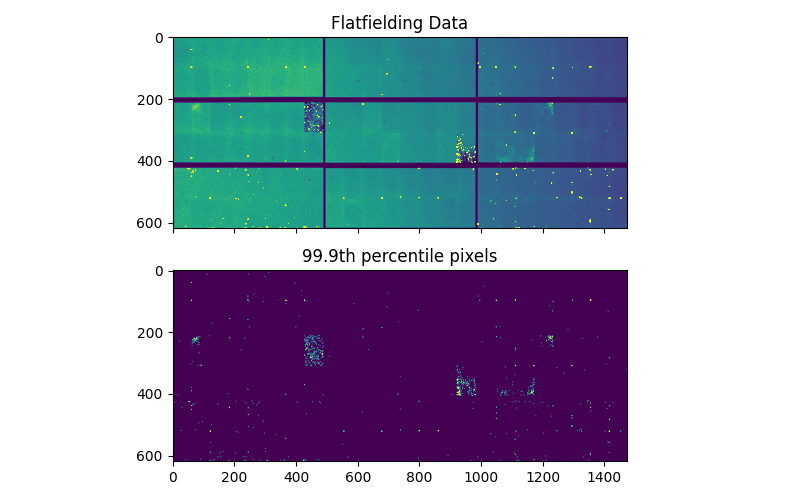

In [4]:
# Past beamline data for flat fielding (normalizing default pixel intensities)
# Note this is done at 2478eV, not all energies.

# # 2024 Cycle 2 Flatfielding
# CYCLE_FLAT = '2024_3'
# PROPOSAL_FLAT= '314483-Freychet-Flatfielding'
# FLAT_FILE = 'GF_flatfield_Sedge_2450uhighg1600_WZY11_wa30deg_2478eV_20s_id701601_000000_WAXS.tif'

# 2024 Cycle 3 Flatfielding
PROPOSAL_FLAT= '314483_Freychet_08'
FLAT_FILE = 'GF_GF_flatfield_Sedge_2450uhighg1600_Y2_06_2477.00eV_wa20deg_id807229_000000_WAXS.tif'

# Compile and load the flatfield path
FLAT_DIR_PATH = f'C:/Datasets/2024-09 SMI/{PROPOSAL_FLAT}/900KW/'
flatfield: npt.NDArray = np.rot90(fabio.open(os.path.join(FLAT_DIR_PATH, FLAT_FILE)).data, 1)

fig,ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))
p = 99.9
percentile = np.percentile(flatfield, p) #99.9th percentile
ax[0].imshow(np.rot90(flatfield, 3), vmin=0, vmax=percentile, interpolation=None)
ax[0].set_title("Flatfielding Data")

erronous =  (flatfield > percentile) * 1.0
ax[1].imshow(np.rot90(erronous,3), vmin=0, vmax=np.max(erronous)/5, interpolation=None)
ax[1].set_title(f"{p}th percentile pixels")
fig.tight_layout()

### Extra functions for SMI Beamline Masking

##### Detector Masking

In [5]:
def apply_detector_mask_to_array(
        mask: npt.NDArray = np.zeros((1475, 195), dtype=bool)
        ) -> npt.NDArray[np.bool]:
        """Sets an array mask for bad pixels; should only be applied to the middle column array"""
        mask[1254:1256, 47] = True
        mask[979:1050, 0:100] = True
        mask[967, 67] = True
        mask[490:555, 100:] = True
        mask[1231:1233, 174] = True
        mask[1414: 1416, 179] = True
        mask[858:860, 5] = True
        mask[414, 6] = True
        mask[394, 138] = True
        mask[364:366, 41] = True
        mask[364:366, 96] = True
        mask[304:306, 96:98] =  True
        mask[988, 188:194] = True
        mask[:, 1] = True
        mask[473, 20] = True
        mask[98, 5] = True
        mask[141, 111] = True
        mask[240:300, 0:50] = True
        mask[300:425, 125:] = True
        mask[181:183, 97:99] = True
        mask[553:555, 99:100] = True
        return mask

def apply_detector_mask(geom: SMI_beamline.SMI_geometry) -> None:
    """Applies a pre-defined mask for the bad pixels in the SMI beamline"""
    for i, mask in enumerate(geom.masks):
        # Dead pixels in the 2nd detector strip.
        if i%3 == 1: # For multiple WAXS images, always masks the 2nd strip.
            apply_detector_mask_to_array(mask)
    return


##### Flatield Masking

In [6]:
FLATFIELD_PERCENTILE = 99.9

# For flatfielding, ignore/mask reigons between detector pixels.
FLATFIELD_SLICES = [slice(0, 195),  # Ign. flatfield above first frame
                    slice(211, 406),# Ign. flatfield outside middle  
                    slice(-195, None)] # Ign. flatfield below first frame
            
def flatfield_mask(flatfield: npt.NDArray = flatfield, 
                   percentile: float = FLATFIELD_PERCENTILE, 
                   min: float | int = 1) -> npt.NDArray[np.bool]:
        """
        Returns a mask of flatfield data as a boolean numpy array.
        
        Masks pixels above the `percentile` (by default 99.9)
        and values less than `min` (by default 1).
        """
        # Calculate the 99.9th percentile of the total flatfield data
        p = np.percentile(flatfield, percentile) #99.9th percentile
        erronous =  flatfield > p
        # Also mask negative and zero pixels
        negative = flatfield < min
        # Return the overlap of the erronous and negative masks.
        return erronous | negative

def apply_flatfield(geom: SMI_beamline.SMI_geometry, 
                    flatfield: npt.NDArray, 
                    percentile: float | int = FLATFIELD_PERCENTILE,
                    min : float | int = 1) -> None:
    """Applies a pre-defined flatfield mask and normalisation for the SMI beamline object"""
    flatmask = flatfield_mask(flatfield=flatfield, percentile=percentile, min = min)
    for i, (mask, img) in enumerate(zip(geom.masks, geom.imgs)):
        fmask_i = flatmask[:, FLATFIELD_SLICES[i % 3]]
        # Apply the masking values
        masking_values = np.where(fmask_i == True)
        mask[masking_values] = True
        # Apply the normalisation 
        # (note: can't use img /= flatfield, as casting doesn't work from int to float)
        # Image requires counts to be int32. Therefore when dividing by the flatfield, make sure every value is less than one.
        flat = flatfield[:, FLATFIELD_SLICES[i%3]] / np.max(flatfield[:, FLATFIELD_SLICES[i%3]] * ~mask)
        flat[flat < 0] = 10000 # avoid negative values
        img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
    
        # Repeat mask for very large values erronously normalised
        mask2 = flatfield_mask(flatfield=img, percentile=percentile, min = 0) # only consider positive values.
        masking_values2 = np.where(mask2 == True)
        mask[masking_values2] = True
    return


##### Show the stages of Flatfield masking

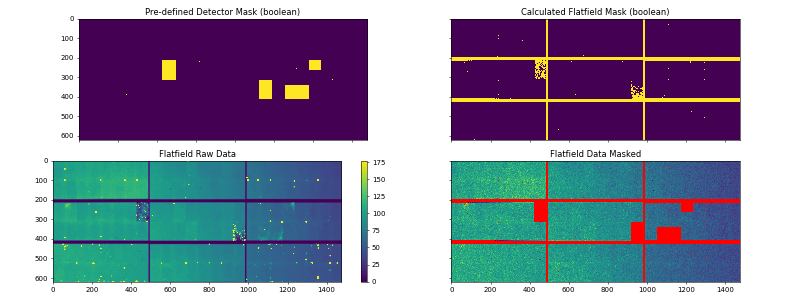

In [7]:
fig,ax = plt.subplots(2,2, figsize=(16,6), dpi=50, sharex=True, sharey=True)

# Detector image is (619, 1475) #619 is 195 * 3 + 2 * 17
# Show the detector masking
det_mask = np.c_[np.zeros((195 + 17, 1475), dtype=bool).T, 
                          apply_detector_mask_to_array(), # 195 pixels
                          np.zeros((195 + 17, 1475),dtype=bool).T]
det_im = ax[0][0].imshow(np.rot90(det_mask,3), interpolation='nearest') # required to prevent interpolation
ax[0][0].set_title("Pre-defined Detector Mask (boolean)")

# Show the flatfield masking
ff_masked = flatfield_mask(flatfield)
ff_masked_im = ax[0][1].imshow(np.rot90(ff_masked,3), interpolation='nearest') # required to prevent interpolation
ax[0][1].set_title("Calculated Flatfield Mask (boolean)")

# Show the flatfield image
ff_im = ax[1][0].imshow(np.rot90(flatfield,3), vmin = 0, vmax = np.percentile(flatfield, FLATFIELD_PERCENTILE))
plt.colorbar(ff_im)
ax[1][0].set_title("Flatfield Raw Data")

# Show the masks on the flatfield image
joined_mask = ff_masked | det_mask
cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
ff_im_masked = ax[1][1].imshow(np.rot90(flatfield,3), interpolation='nearest',
                               vmin = 0, vmax = np.percentile(flatfield, FLATFIELD_PERCENTILE))
ax[1][1].imshow(np.rot90(joined_mask,3), cmap=cmap, interpolation='nearest')
ax[1][1].set_title("Flatfield Data Masked")

fig.tight_layout()


### Data Import

##### Locate the files on your computer and define the output directory

In [8]:
CYCLE: str = '2024_3' #YYYY_[1-3]
PROPOSAL_ID = '316022_McNeil_04' #PPPPPP_[Name]_[#]
## ----------- Path to the raw data -----------

# RAW_PATH = f'D:/Datasets/2024-09 SMI/{CYCLE}/{PROPOSAL_ID}/900KW/'
RAW_DIR = f'C:/Datasets/2024-09 SMI/{PROPOSAL_ID}/900KW/'
display(pd.DataFrame(os.listdir(RAW_DIR), columns=["Filename"])) #use tail or head to display a subset

## ----------- Create/select the results directory -----------
RESULT_DIR = f'C:/Datasets/2024-09 SMI/{PROPOSAL_ID}/angle_scan_results/'
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)
else:
    print("Results path exists!")

Filename
0                            CM_A1_01_a_2445.00eV_ai0.80_wa0_bpm118.055_id779746_000000_WAXS.tif
1                           CM_A1_01_a_2445.00eV_ai0.80_wa20_bpm118.472_id779809_000000_WAXS.tif
2                            CM_A1_01_a_2450.00eV_ai0.80_wa0_bpm119.200_id779747_000000_WAXS.tif
3                           CM_A1_01_a_2450.00eV_ai0.80_wa20_bpm119.501_id779810_000000_WAXS.tif
4                            CM_A1_01_a_2455.00eV_ai0.80_wa0_bpm120.016_id779748_000000_WAXS.tif
...                                                                                          ...
2063  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.500_wa0_bpm119.446_id781575_000000_WAXS.tif
2064  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.600_wa0_bpm119.430_id781576_000000_WAXS.tif
2065  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.700_wa0_bpm119.493_id781577_000000_WAXS.tif
2066  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.800_wa0_bpm119.510_id781578_000000_WAXS.tif
2067  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.900_wa0_bpm119.436_id781579_000000_WAXS.tif

[2068 rows x 1 columns]

Results path exists!


##### Organise files into sample names and data for each detector angle

In [9]:
filename_flags: list[str] = ['wide', '2450']
"""The strings you want included in the files processed."""

# Find all samples
samples: list[str] = []
"""String names of the unique samples matching patterns in `filename_flags`"""
for file in sorted(os.listdir(RAW_DIR)):
     # Define the flags for the files you want to process, by filtering the filename.
     if all([flag in file for flag in filename_flags]):
        # Find the angle of incidence:
        idx = file.find('_ai')
        sample_substring = file[:idx+1]
        # If sample substring not in list of samples, add it!
        if sample_substring not in samples:
            samples.append(sample_substring)

# Find all TIF image measurements
datasets: list[list[str]] = [[] for _ in samples]
count = 0
"""A list for each sample, corresponding to the raw data filenames. 
Each sample list will be an index of anles of incidence."""
for i, sample in enumerate(samples):
        for j, file in enumerate(sorted(os.listdir(RAW_DIR))):
                if all([flag in file for flag in filename_flags + [sample, '.tif']]):
                        datasets[i].append(file)

# Display the number of files for each sample:
display(
      pd.DataFrame([
            (sample, len(datasets[i]))
            for i, sample in enumerate(samples)
      ], columns=["Sample Name", "Number of Files"])
)

Sample Name  Number of Files
0  CM_wideincidentanglescan_A1_01_a_2450.00eV_              139
1  CM_wideincidentanglescan_A1_02_a_2450.00eV_              139
2  CM_wideincidentanglescan_A1_03_a_2450.00eV_              139
3  CM_wideincidentanglescan_A1_04_a_2450.00eV_              139

# Reduction
### Run the first sample to check everything is working and define the Q fit ranges

##### First check sample image exists and looks reasonable!

CM_wideincidentanglescan_A1_01_a_2450.00eV_


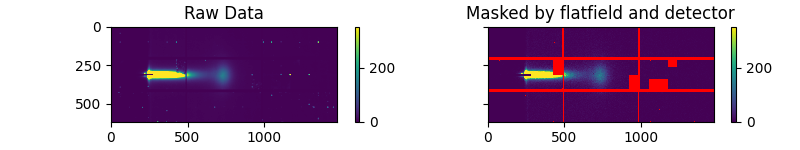

------------------------------
CM_wideincidentanglescan_A1_02_a_2450.00eV_


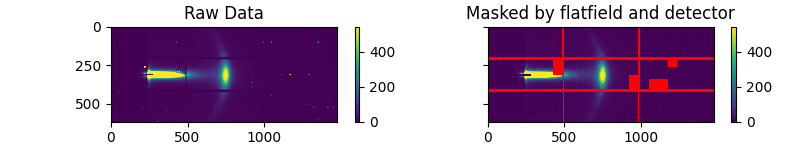

------------------------------
CM_wideincidentanglescan_A1_03_a_2450.00eV_


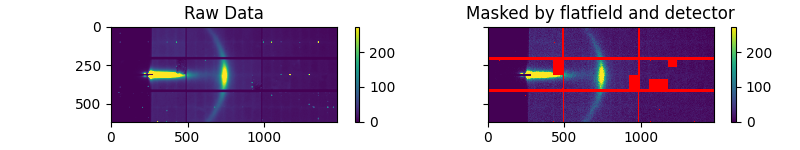

------------------------------
CM_wideincidentanglescan_A1_04_a_2450.00eV_


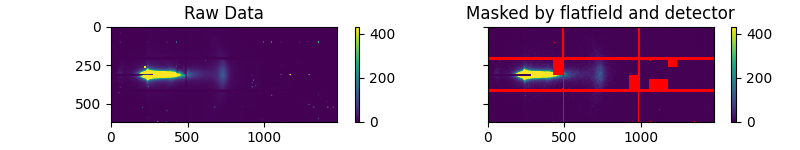

------------------------------


In [10]:
test_file: int = 40
"""The index of each sample's test file"""

for i, sample in enumerate(samples):
        print(sample)
        fig,ax = plt.subplots(1,2, figsize=(8,1.5), sharex=True, sharey=True)
        fname = datasets[i][test_file]
        # fig.suptitle(sample)
        # Use 
        img=fabio.open(os.path.join(RAW_DIR, fname)).data
        mappable = ax[0].imshow(img, vmin=0, vmax=np.percentile(img,99))
        ax[0].set_title("Raw Data")
        plt.colorbar(mappable)
        
        # Show the masks on the flatfield image
        cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
        ff_im_masked = ax[1].imshow(img, interpolation='nearest',
                                vmin = 0, vmax = np.percentile(img, 99))
        ax[1].imshow(np.rot90(joined_mask,3), cmap=cmap, interpolation='nearest')
        ax[1].set_title("Masked by flatfield and detector")
        plt.colorbar(ff_im_masked)
        
        fig.tight_layout()
        plt.show()
        print("------------------------------")

##### Import data via SMI beamline and observe the application of flatfielding.

Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.541_wa0_bpm119.359_id779647_000000_WAXS.tif       2450.0                 0.541

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_02_a_2450.00eV_ai0.541_wa0_bpm119.489_id780174_000000_WAXS.tif       2450.0                 0.541

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_03_a_2450.00eV_ai0.541_wa0_bpm119.612_id780828_000000_WAXS.tif       2450.0                 0.541

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai0.541_wa0_bpm119.633_id781481_000000_WAXS.tif       2450.0                 0.541

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


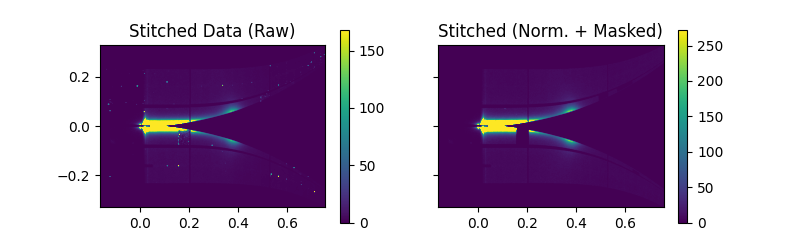

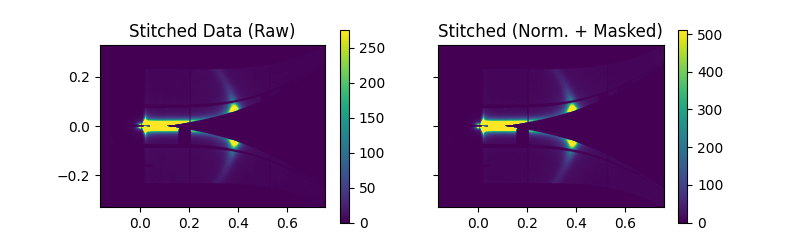

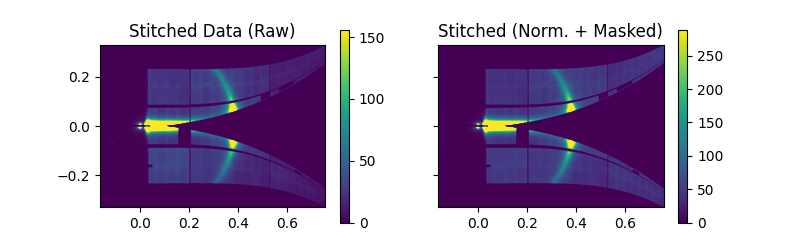

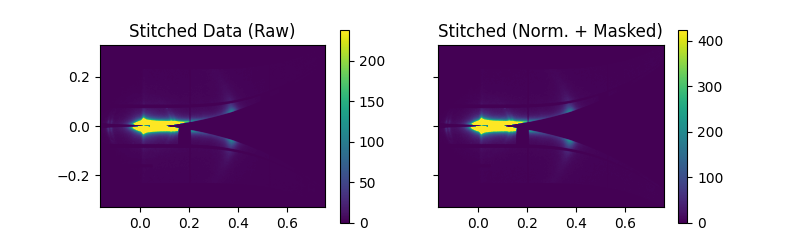

In [11]:
for i, sample in enumerate(samples):
    # Setup a figure and open the file
    fig,ax = plt.subplots(1,2, figsize=(8,2.5), sharex=True, sharey=True)
    fname = datasets[i][test_file]
    
    # Collect the metadata
    en_idx = fname.find('eV_')
    en = float(fname[en_idx-7:en_idx])
    ai_idx = fname.find("_ai")
    ai = float(fname[ai_idx+3:ai_idx+8])
    display(pd.DataFrame([
            (fname, en, ai)
            ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
    
    # Update the geometry
    SMI_waxs.alphai = np.deg2rad(ai)
    SMI_waxs.wav = en2wav(en)
    
    # Plot the unmodified data
    SMI_waxs.open_data(RAW_DIR, [fname])
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)
    # mp = ax[0].imshow(SMI_waxs.img_st,
    #         extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
    mp = ax[0].imshow(np.rot90(SMI_waxs.img_st.T, 2),
            extent=[SMI_waxs.qz[0], SMI_waxs.qz[-1], SMI_waxs.qp[0], SMI_waxs.qp[-1]], 
            vmin=0,
            vmax=np.percentile(SMI_waxs.img_st, 99)
    )
    plt.colorbar(mp)
    ax[0].set_title("Stitched Data (Raw)")
    
    # Plot the flatfield / masked normalized data
    SMI_waxs.open_data(RAW_DIR, [fname])
    apply_detector_mask(SMI_waxs)
    apply_flatfield(SMI_waxs, flatfield)
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)
    # mp = ax[1].imshow(SMI_waxs.img_st,
            # extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
    mp = ax[1].imshow(np.rot90(SMI_waxs.img_st.T,2),
            extent=[SMI_waxs.qz[0], SMI_waxs.qz[-1], SMI_waxs.qp[0], SMI_waxs.qp[-1]], 
            vmin=np.percentile(SMI_waxs.img_st, 1.0), 
            vmax=np.percentile(SMI_waxs.img_st, 99.0)
    )
    plt.colorbar(mp)
    ax[1].set_title("Stitched (Norm. + Masked)")


##### Generate a ROI to check the beam-centre 
###### Also check that the beamcentre is correct by symmetry (unless sample has anisotropic behavour)

Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.541_wa0_bpm119.359_id779647_000000_WAXS.tif       2450.0                 0.541

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_02_a_2450.00eV_ai0.541_wa0_bpm119.489_id780174_000000_WAXS.tif       2450.0                 0.541

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_03_a_2450.00eV_ai0.541_wa0_bpm119.612_id780828_000000_WAXS.tif       2450.0                 0.541

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai0.541_wa0_bpm119.633_id781481_000000_WAXS.tif       2450.0                 0.541

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


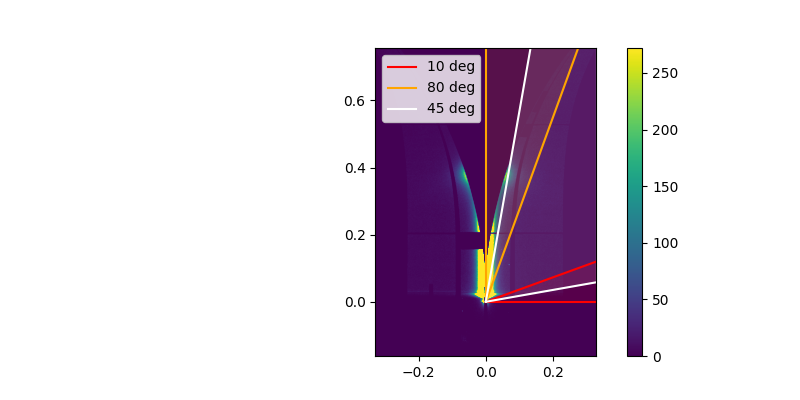

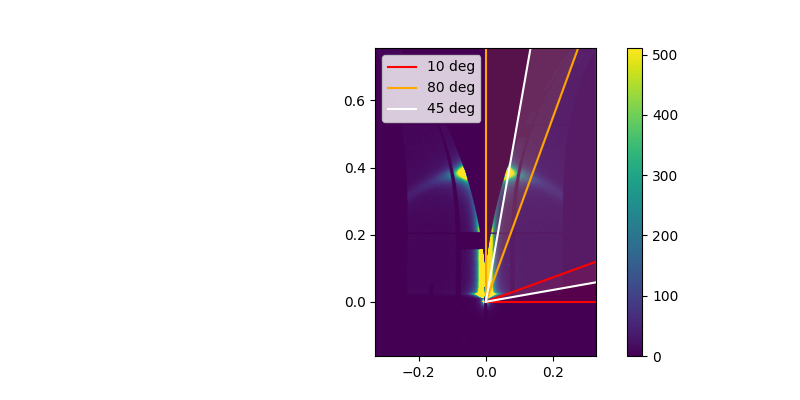

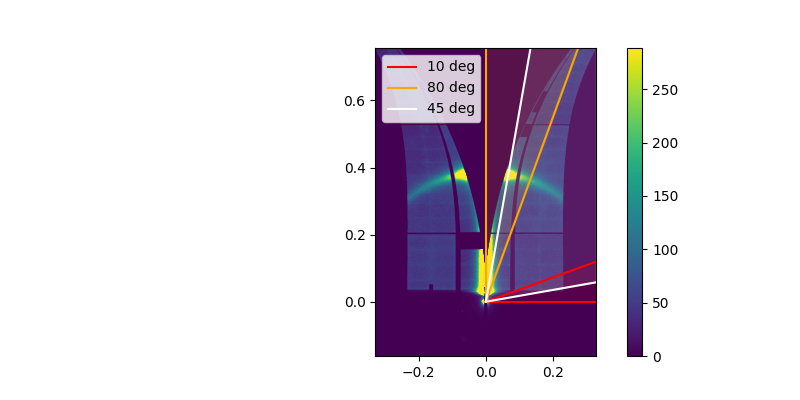

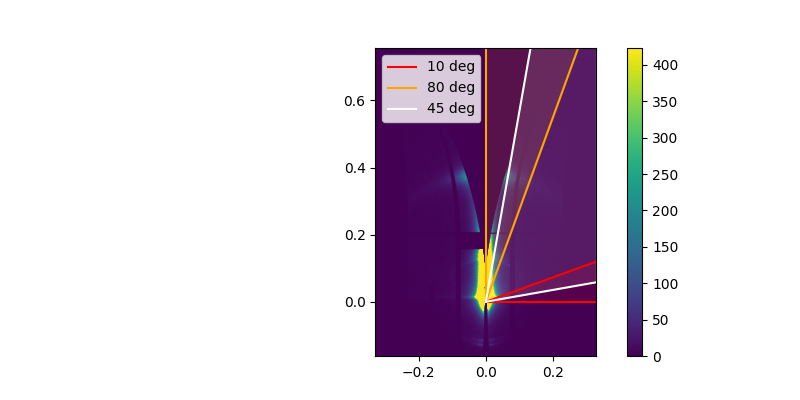

In [12]:
# Define the radial angles
AZIMUTHAL_WIDTH = 10
"""The +- azimuthal width of the orthogonal range"""
AZIMUTHAL_INPLANE = 10
"""The azimuthal angle for the in-plane scattering"""
AZIMUTHAL_OUTOFPLANE = 80
"""The azimuthal angle for the out-of-plane averaging"""
RADIAL_WIDTH = 35
"""The +- azimuthal width for the radial averaging"""
AZIMUTHAL_RADIAL = 45
"""The azimuthal angle for the radial averaging"""

for i, sample in enumerate(samples):
    # Setup a figure and open the file
    fname = datasets[i][test_file]
    
    # Collect the metadata
    en_idx = fname.find('eV_')
    en = float(fname[en_idx-7:en_idx])
    ai_idx = fname.find("_ai")
    ai = float(fname[ai_idx+3:ai_idx+8])
    display(pd.DataFrame([
            (fname, en, ai)
            ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
    
    # Update the geometry
    SMI_waxs.alphai = np.deg2rad(ai)
    SMI_waxs.wav = en2wav(en)

    # Show the angles on a plot
    fig,ax = plt.subplots(1,1, figsize=(8,4), sharex=True, sharey=True)
    ax.set_ylim(SMI_waxs.qz[0], SMI_waxs.qz[-1])
    ax.set_xlim(SMI_waxs.qp[0], SMI_waxs.qp[-1])

    SMI_waxs.open_data(RAW_DIR, [fname])
    apply_detector_mask(SMI_waxs)
    apply_flatfield(SMI_waxs, flatfield)
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)
    # mp = ax[1].imshow(SMI_waxs.img_st,
            # extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
    mp = ax.imshow(SMI_waxs.img_st,
            extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
            vmin=np.percentile(SMI_waxs.img_st, 1.0), 
            vmax=np.percentile(SMI_waxs.img_st, 99.0)
    )
    plt.colorbar(mp)

    # Plot the azimuthal and radial angles
    colors = ['r', 'orange', 'white'][::-1]
    for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
            # Generate a set of x points to plot lines of.
            q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
            # Calculate the x and y gradients for the lines
            m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
            m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
            # Calculate the x & y values for the lines
            q_x1 = q_x if m1 != np.inf else np.zeros(100)
            q_x2 = q_x if m2 != np.inf else np.zeros(100)
            y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
            y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
            # Plot the lines
            color = colors.pop()
            ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
            ax.plot(q_x2, y2, color=color, linestyle='-')
            # If gradient is inf, calculate an alternative fill between
            if m2 == np.inf:
                    ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
            else:
                    ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
    ax.legend()


##### Calculate the azimuthal/radial averages

Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.541_wa0_bpm119.359_id779647_000000_WAXS.tif       2450.0                 0.541

Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_02_a_2450.00eV_ai0.541_wa0_bpm119.489_id780174_000000_WAXS.tif       2450.0                 0.541

Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_03_a_2450.00eV_ai0.541_wa0_bpm119.612_id780828_000000_WAXS.tif       2450.0                 0.541

Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai0.541_wa0_bpm119.633_id781481_000000_WAXS.tif       2450.0                 0.541

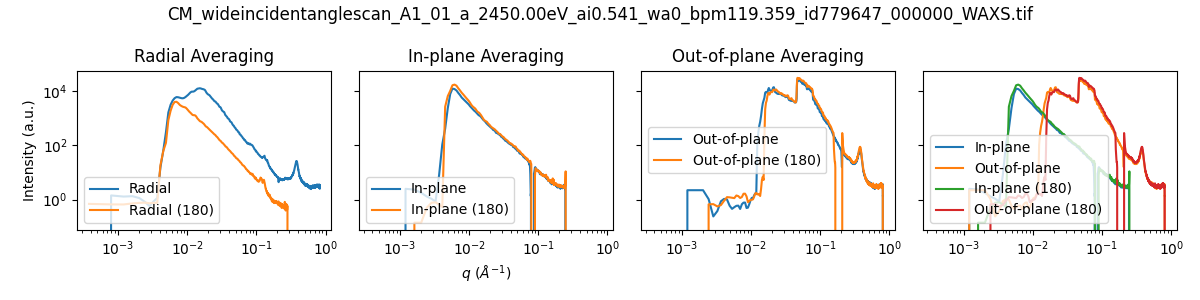

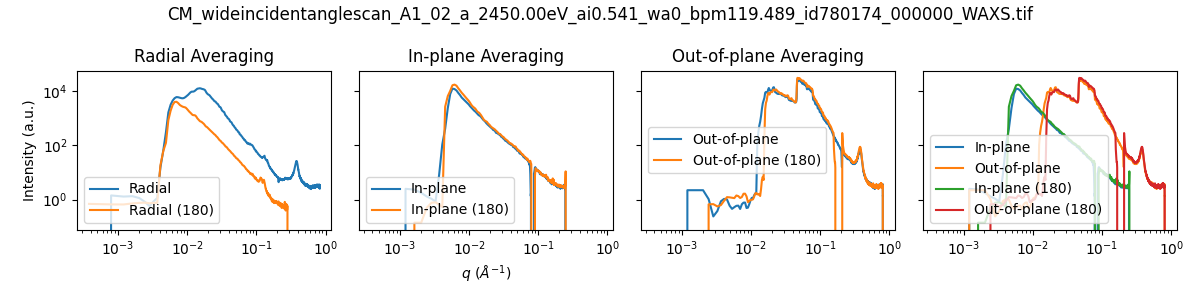

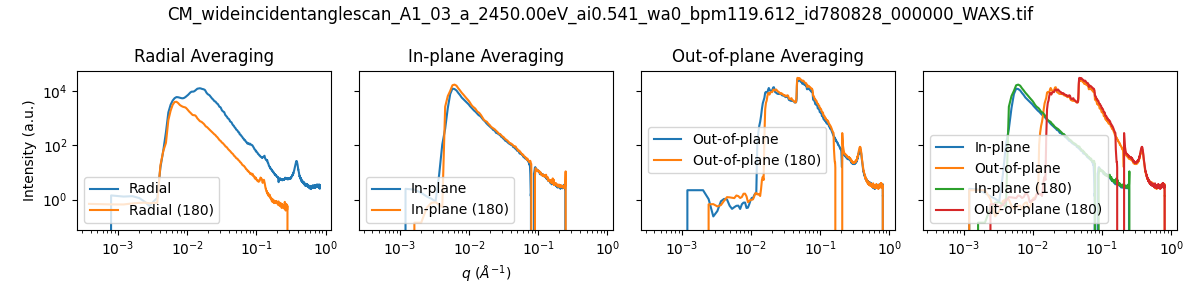

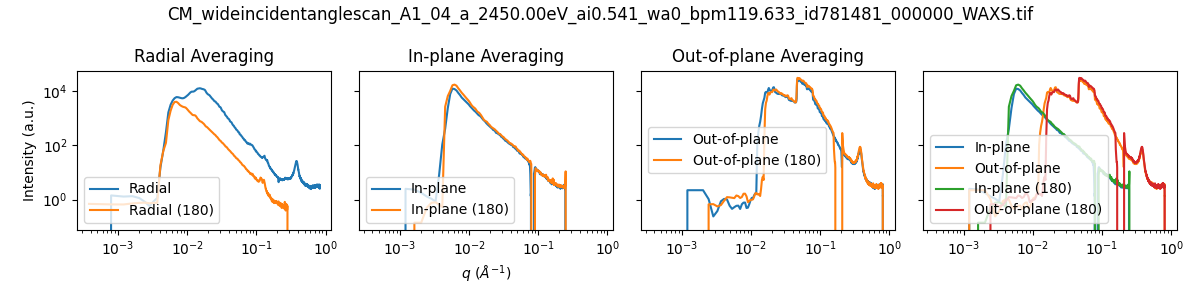

In [13]:
NPOINTS_RADIAL_AVE: int = 2000 # Use a number the is consistent with the pixel density?

for i, sample in enumerate(samples):
    # Setup a figure and open the file
    fname = datasets[i][test_file]
    
    # Collect the metadata
    en_idx = fname.find('eV_')
    en = float(fname[en_idx-7:en_idx])
    ai_idx = fname.find("_ai")
    ai = float(fname[ai_idx+3:ai_idx+8])
    display(pd.DataFrame([
            (fname, en, ai)
            ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
    
    # Update the geometry
    SMI_waxs.alphai = np.deg2rad(ai)
    SMI_waxs.wav = en2wav(en)


    # Generate radial averages
    fig,ax = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
    fig.suptitle(fname)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")

    # In plane and out of plane
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_IP, I0_IP = SMI_waxs.q_rad, SMI_waxs.I_rad

    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_OOP, I0_OOP = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Repeat IP and OOP for the consistency checking
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_IP2, I0_IP2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_OOP2, I0_OOP2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Radial averaging
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[AZIMUTHAL_RADIAL - RADIAL_WIDTH , AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_R, I0_R = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Repeat radial averaging for consistency checking
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[180-AZIMUTHAL_RADIAL - RADIAL_WIDTH , 180-AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_R2, I0_R2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Plot the radial averages
    ax[0].plot(q0_R, I0_R, label="Radial")
    ax[0].plot(q0_R2, I0_R2, label="Radial (180)")
    ax[0].set_title("Radial Averaging")
    ax[0].set_ylabel("Intensity (a.u.)")
    # Plot the in-plane and out-of-plane averages
    ax[1].plot(q0_IP, I0_IP, label="In-plane")
    ax[1].plot(q0_IP2, I0_IP2, label="In-plane (180)")
    ax[1].set_title("In-plane Averaging")
    ax[1].set_xlabel("$q$ ($Å^{-1}$)")
    ax[2].plot(q0_OOP, I0_OOP, label="Out-of-plane")
    ax[2].plot(q0_OOP2, I0_OOP2, label="Out-of-plane (180)")
    ax[2].set_title("Out-of-plane Averaging")
    # Overlap the in-plane and out-of-plane averages to check for consistency
    ax[3].plot(q0_IP, I0_IP, label="In-plane")
    ax[3].plot(q0_OOP, I0_OOP, label="Out-of-plane")
    ax[3].plot(q0_IP2, I0_IP2, label="In-plane (180)")
    ax[3].plot(q0_OOP2, I0_OOP2, label="Out-of-plane (180)")

    for ax in ax:
            ax.legend()
    fig.tight_layout()

### Setup Fitting
##### Define q regions for truncation, where summation can be performed to observe changes in amplitude

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\2026994617.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(max([len(VERT_PEAKS), len(HOR_PEAKS), len(RAD_PEAKS)]), 4, figsize=(14,4))


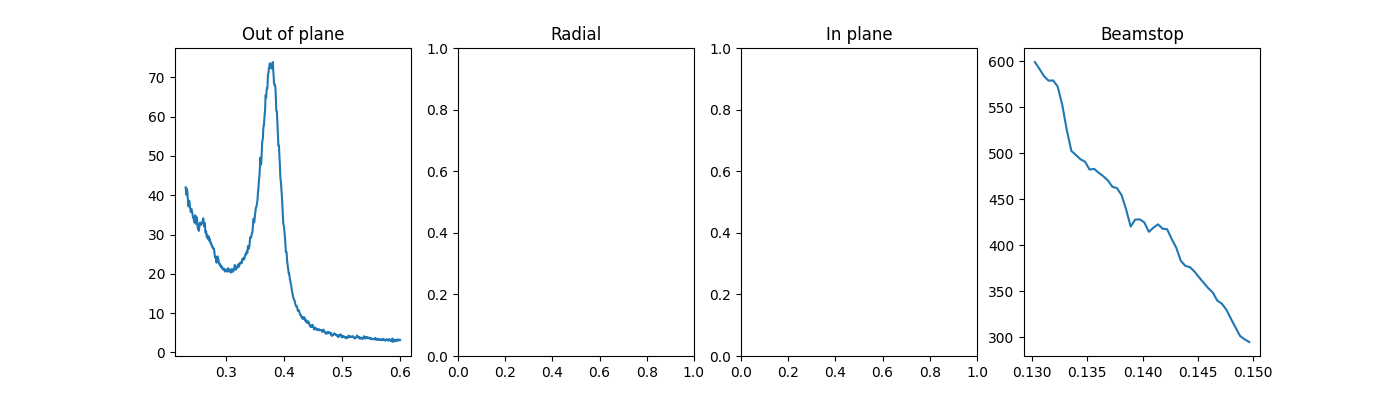

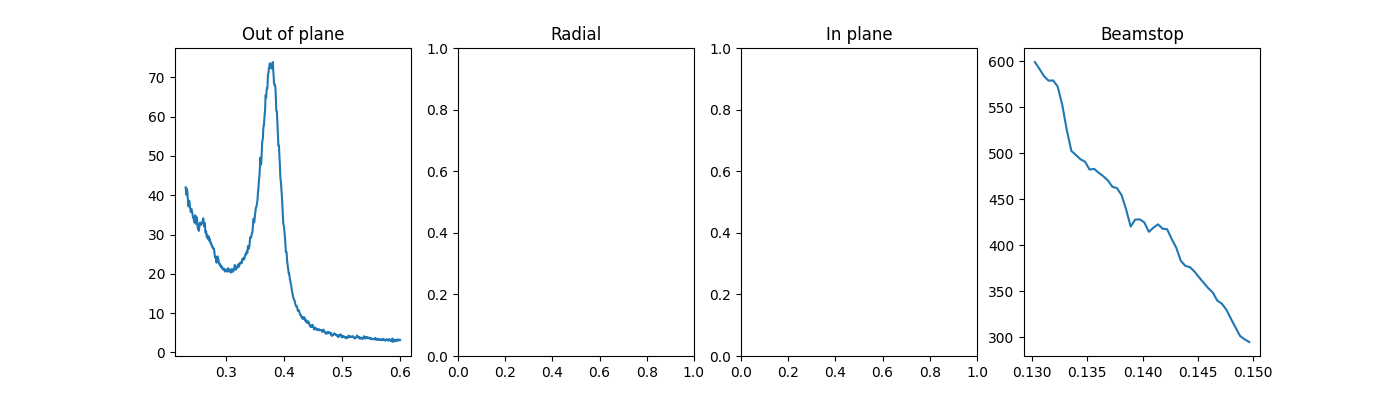

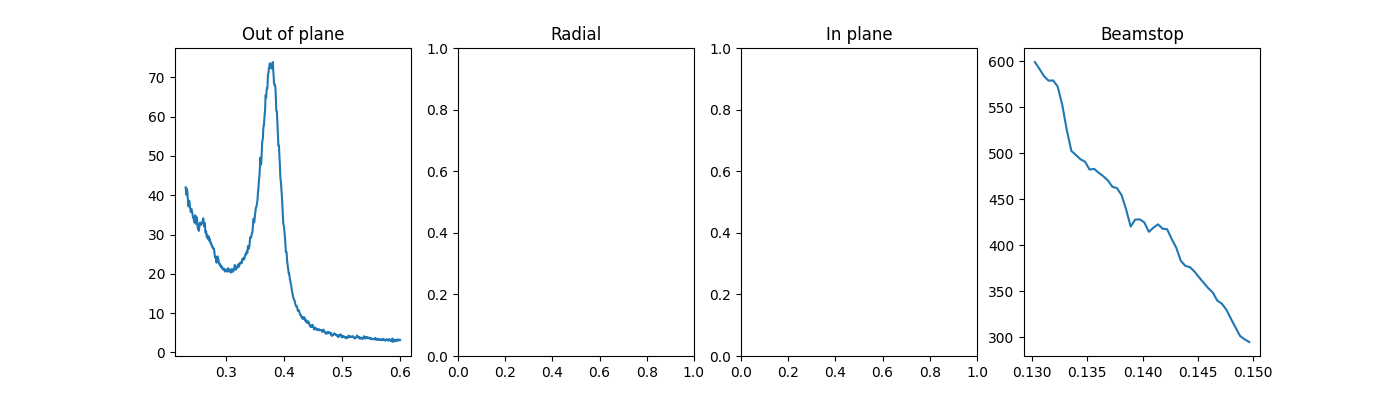

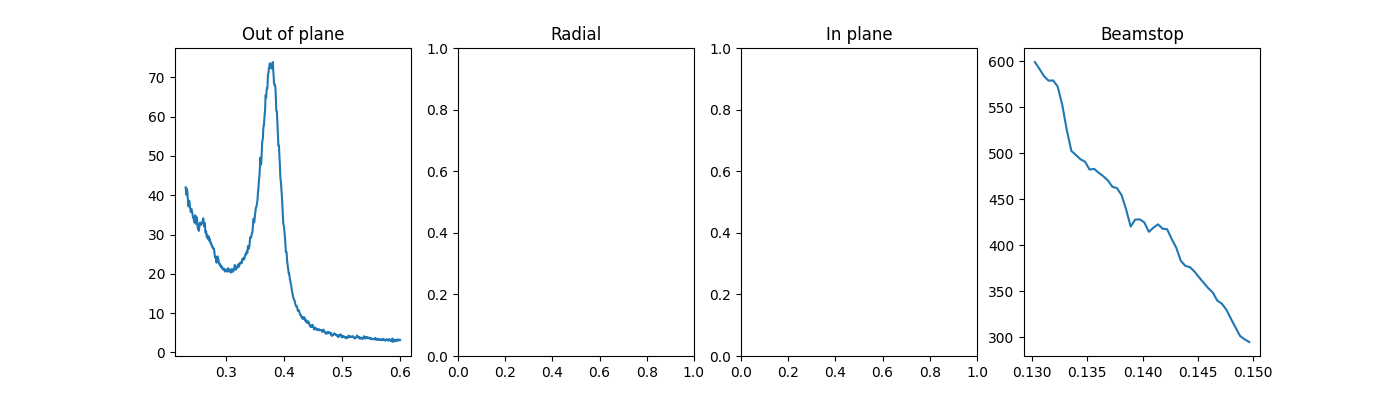

In [14]:
# Define the q-range for the peaks
VERT_PEAKS: list[tuple[float, float]] = [(0.23, 0.6),
                                    # (0.5, 0.75), etc.
                                    ]
"""A list of tuples defining the q-range fitting for each peak of interest"""
HOR_PEAKS: list[tuple[float, float]] = []
RAD_PEAKS: list[tuple[float, float]] = []

VERT_BEAMSTOP: tuple[float, float] = (0.13, 0.15)
"""A q-range specifying a q-range to collect the change in beamstop intensity"""

for i, sample in enumerate(samples):
    # Setup a figure and open the file
    fname = datasets[i][test_file]
    
    # Collect the metadata
    en_idx = fname.find('eV_')
    en = float(fname[en_idx-7:en_idx])
    ai_idx = fname.find("_ai")
    ai = float(fname[ai_idx+3:ai_idx+8])
    
    # Update the geometry
    SMI_waxs.alphai = np.deg2rad(ai)
    SMI_waxs.wav = en2wav(en)

    # In plane and out of plane
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_IP, I0_IP = SMI_waxs.q_rad, SMI_waxs.I_rad

    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_OOP, I0_OOP = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Repeat IP and OOP for the consistency checking
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_IP2, I0_IP2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_OOP2, I0_OOP2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Radial averaging
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[AZIMUTHAL_RADIAL - RADIAL_WIDTH , AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_R, I0_R = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Repeat radial averaging for consistency checking
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[180-AZIMUTHAL_RADIAL - RADIAL_WIDTH , 180-AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_R2, I0_R2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Find the q-range to the region of interest
    if len(VERT_PEAKS) > 0:
        idx_OOP = np.where((q0_OOP > np.min(VERT_PEAKS)) & (q0_OOP < np.max(VERT_PEAKS)))
    else:
        idx_OOP = np.arange(len(q0_OOP))
    if len(HOR_PEAKS) > 0:
        idx_IP = np.where((q0_IP > np.min(HOR_PEAKS)) & (q0_IP < np.max(HOR_PEAKS)))
    else:
        idx_IP = np.arange(len(q0_IP))
    if len(RAD_PEAKS) > 0:
        idx_R = np.where((q0_R > np.min(RAD_PEAKS)) & (q0_R < np.max(RAD_PEAKS)))
    else:
        idx_R = np.arange(len(q0_R))
    # Collect the beamstop region
    idx_BS = np.where((q0_OOP > np.min(VERT_BEAMSTOP)) & (q0_OOP < np.max(VERT_BEAMSTOP)))
        
    # Truncate the data to the region of interest
    q0_OOP_TR, I0_OOP_TR = q0_OOP[idx_OOP], I0_OOP[idx_OOP]
    q0_IP_TR, I0_IP_TR = q0_IP[idx_IP], I0_IP[idx_IP]
    q0_R_TR, I0_R_TR = q0_R[idx_R], I0_R[idx_R]

    # Plot the data
    fig, ax = plt.subplots(max([len(VERT_PEAKS), len(HOR_PEAKS), len(RAD_PEAKS)]), 4, figsize=(14,4))
    if len(ax.shape) == 1:
        ax = ax.reshape(1,4)
    for i, peak in enumerate(VERT_PEAKS):
        ax[i][0].plot(q0_OOP_TR, I0_OOP_TR, label="Out of plane")
    for i, peak in enumerate(RAD_PEAKS):
        ax[i][1].plot(q0_R_TR, I0_R_TR, label="Radial")
    for i, peak in enumerate(HOR_PEAKS):
        ax[i][2].plot(q0_IP_TR, I0_IP_TR, label="In plane")
    ax[0][0].set_title("Out of plane")
    ax[0][1].set_title("Radial")
    ax[0][2].set_title("In plane")

    # Plot the area under the beamstop region
    ax[0][3].plot(q0_OOP[idx_BS], I0_OOP[idx_BS], label="Beamstop")
    ax[0][3].set_title("Beamstop")

##### Attempt some fitting of the peaks
###### Define the peakfit functions

In [15]:
power_law = lambda x, a=1, b=-1, c=0: a * (x-c)**b
"""A power law function for fitting the data

Parameters
----------
    a : float
        The amplitude of the power law, by default 1
    b : float
        The power of the power law, by default -1
    c : float
        The translational offset of the power law, by default 0
"""

lorentz = lambda x, a=1, b=1, c=1: a * c / ((x - b)**2 + c**2)
"""A Lorentzian function for fitting the data

Parameters
----------
    a : float
        The amplitude of the Lorentzian, by default 1
    b : float
        The peak position of the Lorentzian, by default 1
    c : float
        The width of the Lorentzian, by default 1
"""

gauss = lambda x, a=1, b=1, c=1: a * np.exp(-((x - b)**2) / (2 * c**2))
"""A Gaussian function for fitting the data

Parameters
----------
    a : float
        The amplitude of the Gaussian, by default 1
    b : float
        The peak position of the Gaussian, by default 1
    c : float
        The width of the Gaussian, by default 1
"""
# # With power law centre:
# fit_fn_lor = lambda x, a,b,c,d,e,f,g: np.sqrt((lorentz(x,a,b,c) + power_law(x,d,e,f))**2 + g**2)
# fit_fn_lor_log = lambda x, a,b,c,d,e,f,g: np.log(fit_fn_lor(x,a,b,c,d,e,f,g))
# fit_fn_gau = lambda x, a,b,c,d,e,f,g: np.sqrt((gauss(x,a,b,c) + power_law(x,d,e,f))**2 + g**2)
# fit_fn_gau_log = lambda x, a,b,c,d,e,f,g: np.log(fit_fn_gau(x,a,b,c,d,e,f,g))
# fit_fn_guess = tuple[float, float, float, float, float, float, float]
# # Without power law centre:
# fit_fn_lor = lambda x, a,b,c,d,e,f: np.sqrt((lorentz(x,a,b,c) + power_law(x,d,e))**2 + f**2)
# fit_fn_lor_log = lambda x, a,b,c,d,e,f: np.log(fit_fn_lor(x,a,b,c,d,e,f))
# fit_fn_gau = lambda x, a,b,c,d,e,f: np.sqrt((gauss(x,a,b,c) + power_law(x,d,e))**2 + f**2)
# fit_fn_gau_log = lambda x, a,b,c,d,e,f: np.log(fit_fn_gau(x,a,b,c,d,e,f))
# fit_fn_guess = tuple[float, float, float, float, float, float]
# Without power law centre or constant:
fit_fn_lor = lambda x, a,b,c,d,e: (lorentz(x,a,b,c) + power_law(x,d,e))
fit_fn_lor_log = lambda x, a,b,c,d,e: np.log(fit_fn_lor(x,a,b,c,d,e))
fit_fn_gau = lambda x, a,b,c,d,e: ((gauss(x,a,b,c) + power_law(x,d,e))**2)
fit_fn_gau_log = lambda x, a,b,c,d,e: np.log(fit_fn_gau(x,a,b,c,d,e))
fit_fn_guess = tuple[float, float, float, float, float]

##### Create a reasonable guess close to the optimum

Gauss Amplitude  Gauss Centre  Gauss Width  Powerlaw Amplitude  Powerlaw Power
Peak #0 Fit           5.061194      0.376531     0.020683            0.906772       -1.344345
Peak #0 Error         0.018442      0.000083     0.000111            0.012855        0.010788

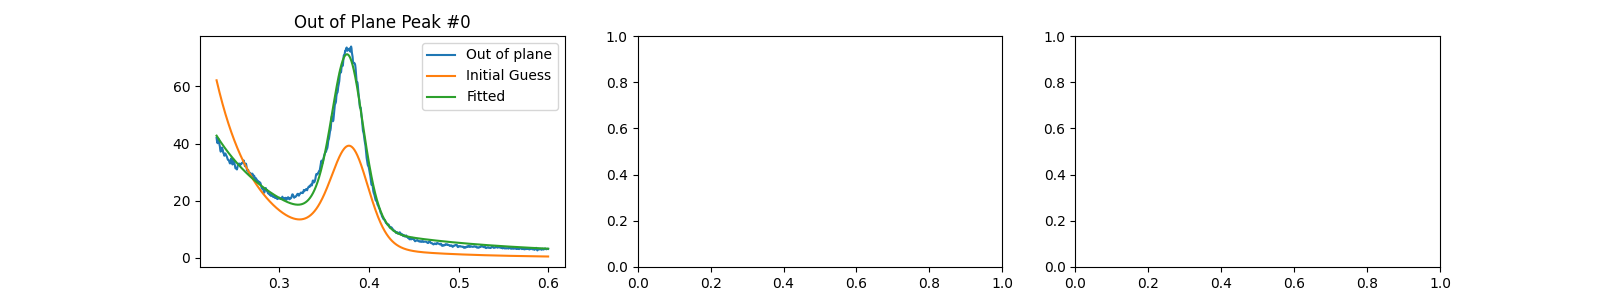

In [16]:
# Define the initial guesses for the peaks
VERT_GUESSES: list[fit_fn_guess] = [
    # (50, 0.38, 0.025, 2, -2.5, 0, 0)
    # (50, 0.38, 0.025, 2, -2.5, 0)
    (4, 0.38, 0.025, 0.2, -2.5)
    
]
HOR_GUESSES: list[fit_fn_guess] = []
RAD_GUESSES: list[fit_fn_guess] = []

#Bounds
# lb = [0, 0, 0, -np.inf, -np.inf, -np.inf, -np.inf]
# ub = [np.inf, np.inf, np.inf, np.inf, 0, np.inf, np.inf]
# lb = [0, 0, 0, -np.inf, -np.inf, -np.inf]
# ub = [np.inf, np.inf, np.inf, np.inf, 0, np.inf]
lb = [0, 0, 0, 0, -np.inf]
ub = [np.inf, np.inf, np.inf, np.inf, 0]
bounds = (lb, ub)

# Check the number of guesses matches the number of peaks
assert len(VERT_PEAKS) == len(VERT_GUESSES), "The number of guesses must match the number of peaks"
assert len(HOR_PEAKS) == len(HOR_GUESSES), "The number of guesses must match the number of peaks"
assert len(RAD_PEAKS) == len(RAD_GUESSES), "The number of guesses must match the number of peaks"

# Display the initial guesses over the data
N = max([len(VERT_PEAKS), len(HOR_PEAKS), len(RAD_PEAKS)])
fig, ax = plt.subplots(N, 3, figsize=(16,3*N))
if len(ax.shape) == 1:
    ax = ax.reshape(1,3)

VERT_OPT, VERT_COV = [], []
HOR_OPT, HOR_COV = [], []
RAD_OPT, RAD_COV = [], []
for i, peak in enumerate(VERT_PEAKS):
    ax[i][0].set_title(f"Out of Plane Peak #{i}")
    ax[i][0].plot(q0_OOP_TR, I0_OOP_TR, label="Out of plane")
    ax[i][0].plot(q0_OOP_TR, fit_fn_gau(q0_OOP_TR, *VERT_GUESSES[i]), label="Initial Guess")
    # ax[i][0].plot(q0_OOP_TR, fit_fn_lor(q0_OOP_TR, *VERT_GUESSES[i]), label="Initial Guess")
    popt, pcov = curve_fit(fit_fn_gau, q0_OOP_TR, I0_OOP_TR, p0=VERT_GUESSES[i], maxfev=10000, bounds=bounds)
    # popt, pcov = curve_fit(fit_fn_lor_log, q0_OOP_TR, np.log(I0_OOP_TR), p0=VERT_GUESSES[i], maxfev=1000, bounds=bounds)
    ax[i][0].plot(q0_OOP_TR, fit_fn_gau(q0_OOP_TR, *popt), label="Fitted")
    # ax[i][0].plot(q0_OOP_TR, fit_fn_lor(q0_OOP_TR, *popt), label="Fitted")
    ax[i][0].legend()
    # gauss_labels = ["Gauss Amplitude", "Gauss Centre", "Gauss Width", "Powerlaw Amplitude", "Powerlaw Power", "Powerlaw Centre", "Offset"]
    # gauss_labels = ["Gauss Amplitude", "Gauss Centre", "Gauss Width", "Powerlaw Amplitude", "Powerlaw Power", "Offset"]
    gauss_labels = ["Gauss Amplitude", "Gauss Centre", "Gauss Width", "Powerlaw Amplitude", "Powerlaw Power"]
    display(pd.DataFrame(
        [popt, np.sqrt(np.diag(pcov))],
        columns=gauss_labels,
        index=[f"Peak #{i} Fit", f"Peak #{i} Error"]
    ))
    VERT_OPT.append(popt)
    VERT_COV.append(pcov)

### Use Monte-Carlo Markov Chains to see if the Least Squares solution is really a good fit of random variables
##### Define the likelihood, prior and probability functions

In [17]:
# Use emcee to perform a Bayesian fit for the model.
def log_likelihood(theta: fit_fn_guess, x: npt.NDArray, y: npt.NDArray, yerr: npt.NDArray) -> float:
    model_y = fit_fn_gau(x, *theta)
    sigma2 = yerr**2 #+ model_y**2 # + np.exp(2 * logf) * model_y**2 ## Sometimes add a variance term of a fractional amount
    return -0.5 * np.sum((y - model_y)**2 / sigma2 )#+ np.log(sigma2))

def log_prior(theta: fit_fn_guess) -> float:
    # a, b, c, d, e, f, g = theta
    # a, b, c, d, e, f = theta
    a, b, c, d, e = theta
    # Define reasonable bounds for the parameters
    if (0 < a < 1.0e6 # Gaussian Amplitude
        and 0.2 < b < 0.6 # Gaussian Centre
        and 0 < c < 0.1 # Gaussian Width
        and 0 < d < 1.0e6 # Powerlaw Amplitude
        and -10 < e < -0.5 # Powerlaw Power
        # and -1.0 < f < 1.0 # Powerlaw Centre
        # and -20.0 < f < 20.0 # Offset
        ):
        return 0.0
    return -np.inf

def log_probability(theta: fit_fn_guess, x: npt.NDArray, y: npt.NDArray, yerr: npt.NDArray) -> float:
    lp = log_prior(theta)
    # Check if nan
    if np.isnan(lp):
        print("Nan:", theta)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

# Test the log_probability function
log_probability(VERT_GUESSES[0], q0_OOP_TR, I0_OOP_TR, np.sqrt(I0_OOP_TR))

np.float64(-1434.7766864741807)

##### Use emcee sampler to run N walkers

In [18]:
# Use the data from the first vert peak
popt = VERT_OPT[0]
pcov = VERT_COV[0]
qmin, qmax = VERT_PEAKS[0]
idxs = np.where((q0_OOP_TR > qmin) & (q0_OOP_TR < qmax))
x = q0_OOP_TR[idxs]
y = I0_OOP_TR[idxs]
yerr = np.sqrt(y)

start = time.time()

# Use the model on the first vert peak.
N = 200
pos = popt * np.ones((N, len(popt))) * (1 + (1.0e-2 * np.random.randn(N, len(popt)) - 5.0e-3))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
M = 2000
sampler.run_mcmc(pos, M, progress=True)
max_tau = None
while max_tau is None:
    try:
        tau = sampler.get_autocorr_time()
        max_tau = np.max(tau)
    except emcee.autocorr.AutocorrError as e:
        tau_estimate = int(np.max(e.tau))
        print(f"Estimated max tau: {tau_estimate}, running for {50*tau_estimate} more steps.")
        sampler.run_mcmc(None, tau_estimate * 50, progress=True)
    
end = time.time()
print(f"Time taken: {end - start:.1f} seconds.")

Estimated max tau: 55, running for 2750 more steps.
emcee: Exception while calling your likelihood function:
  params: [ 5.09665878  0.37576139  0.02088901  0.81019382 -1.42953551]
  args: (array([0.23003279, 0.23044509, 0.23085739, 0.2312697 , 0.231682  ,
       0.23209431, 0.23250661, 0.23291891, 0.23333122, 0.23374352,
       0.23415582, 0.23456813, 0.23498043, 0.23539274, 0.23580504,
       0.23621734, 0.23662965, 0.23704195, 0.23745425, 0.23786656,
       0.23827886, 0.23869116, 0.23910347, 0.23951577, 0.23992808,
       0.24034038, 0.24075268, 0.24116499, 0.24157729, 0.24198959,
       0.2424019 , 0.2428142 , 0.2432265 , 0.24363881, 0.24405111,
       0.24446342, 0.24487572, 0.24528802, 0.24570033, 0.24611263,
       0.24652493, 0.24693724, 0.24734954, 0.24776184, 0.24817415,
       0.24858645, 0.24899876, 0.24941106, 0.24982336, 0.25023567,
       0.25064797, 0.25106027, 0.25147258, 0.25188488, 0.25229718,
       0.25270949, 0.25312179, 0.2535341 , 0.2539464 , 0.2543587 ,
      

Traceback (most recent call last):
  File "C:\Users\Mr_G\AppData\Local\Temp\ipykernel_20116\3680309537.py", line 25, in <module>
    tau = sampler.get_autocorr_time()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Documents\Github\smi-analysis\venv\Lib\site-packages\emcee\ensemble.py", line 621, in get_autocorr_time
    return self.backend.get_autocorr_time(**kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Documents\Github\smi-analysis\venv\Lib\site-packages\emcee\backends\backend.py", line 150, in get_autocorr_time
    return thin * autocorr.integrated_time(x, **kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Documents\Github\smi-analysis\venv\Lib\site-packages\emcee\autocorr.py", line 120, in integrated_time
    raise AutocorrError(tau_est, msg)
emcee.autocorr.AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau

KeyboardInterrupt: 

In [19]:
# # Use the data from the first vert peak
# popt = VERT_OPT[0]
# pcov = VERT_COV[0]
# qmin, qmax = VERT_PEAKS[0]
# idxs = np.where((q0_OOP_TR > qmin) & (q0_OOP_TR < qmax))
# x = q0_OOP_TR[idxs]
# y = I0_OOP_TR[idxs]
# yerr = np.sqrt(y)


# with multiprocessing.Pool() as pool:
#     print("Starting")
#     start = time.time()
#     # Use the model on the first vert peak.
#     N = 200
#     pos = popt * np.ones((N, len(popt))) * (1 + (1.0e-2 * np.random.randn(N, len(popt)) - 5.0e-3))
#     nwalkers, ndim = pos.shape

#     sampler = emcee.EnsembleSampler(
#         nwalkers, ndim, log_probability, args=(x, y, yerr), pool=pool
#     )
#     M = 2000
#     sampler.run_mcmc(pos, M, progress=True)
#     max_tau = None
#     while max_tau is None:
#         try:
#             tau = sampler.get_autocorr_time()
#             max_tau = np.max(tau)
#         except emcee.autocorr.AutocorrError as e:
#             tau_estimate = int(np.max(e.tau))
#             print(f"Estimated max tau: {tau_estimate}, running for {50*tau_estimate} more steps.")
#             sampler.run_mcmc(None, tau_estimate * 50, progress=True)
        
#     end = time.time()
#     print(f"Time taken: {end - start:.1f} seconds.")

In [20]:
raise RuntimeError("STOP HERE.")

RuntimeError: STOP HERE.

Text(0.5, 0.98, 'Chain Output - Corr time 75.08')

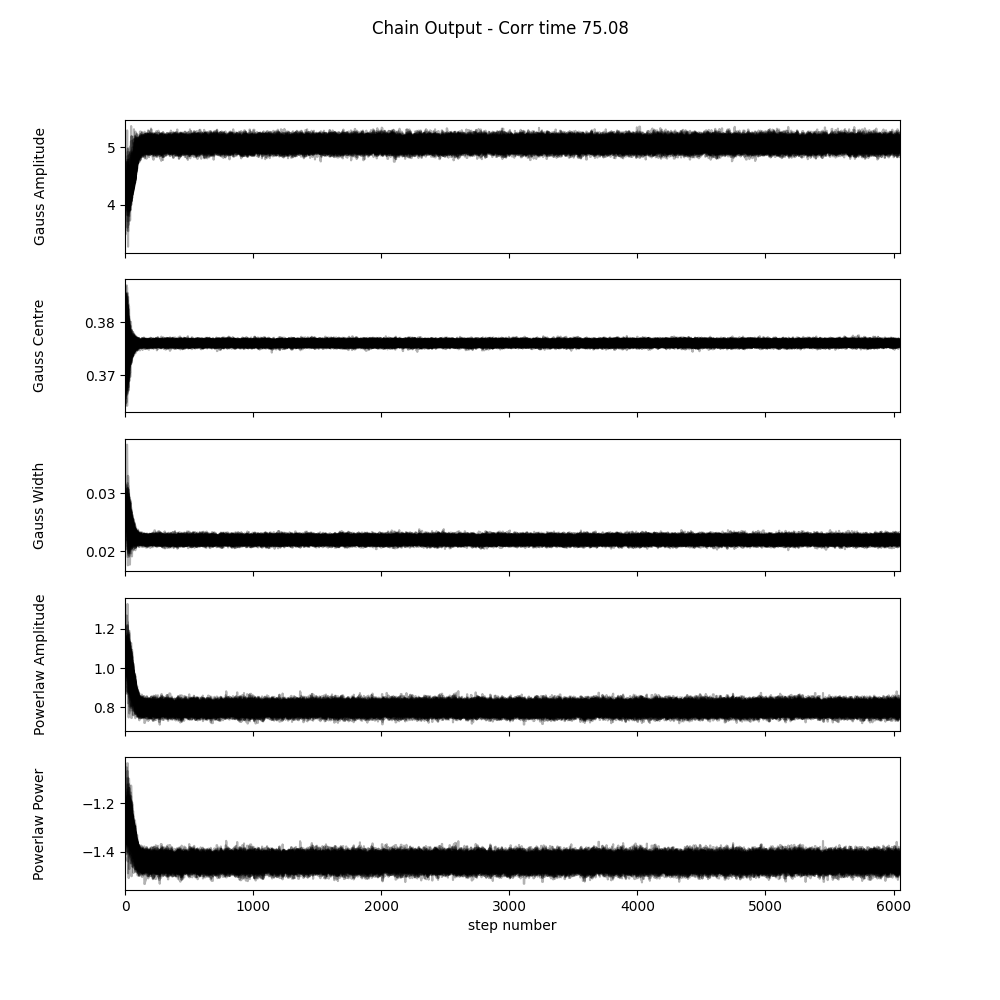

In [254]:
### Display the chain output and estimate where the burn-in period (tau) is.
fig, axes = plt.subplots(len(gauss_labels), figsize=(10, 2*len(gauss_labels)), sharex=True)
MC_samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(MC_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(MC_samples))
    ax.set_ylabel(gauss_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
tau_max = np.max(tau)
fig.suptitle(f"Chain Output - Corr time = {tau_max:0.2f} steps")

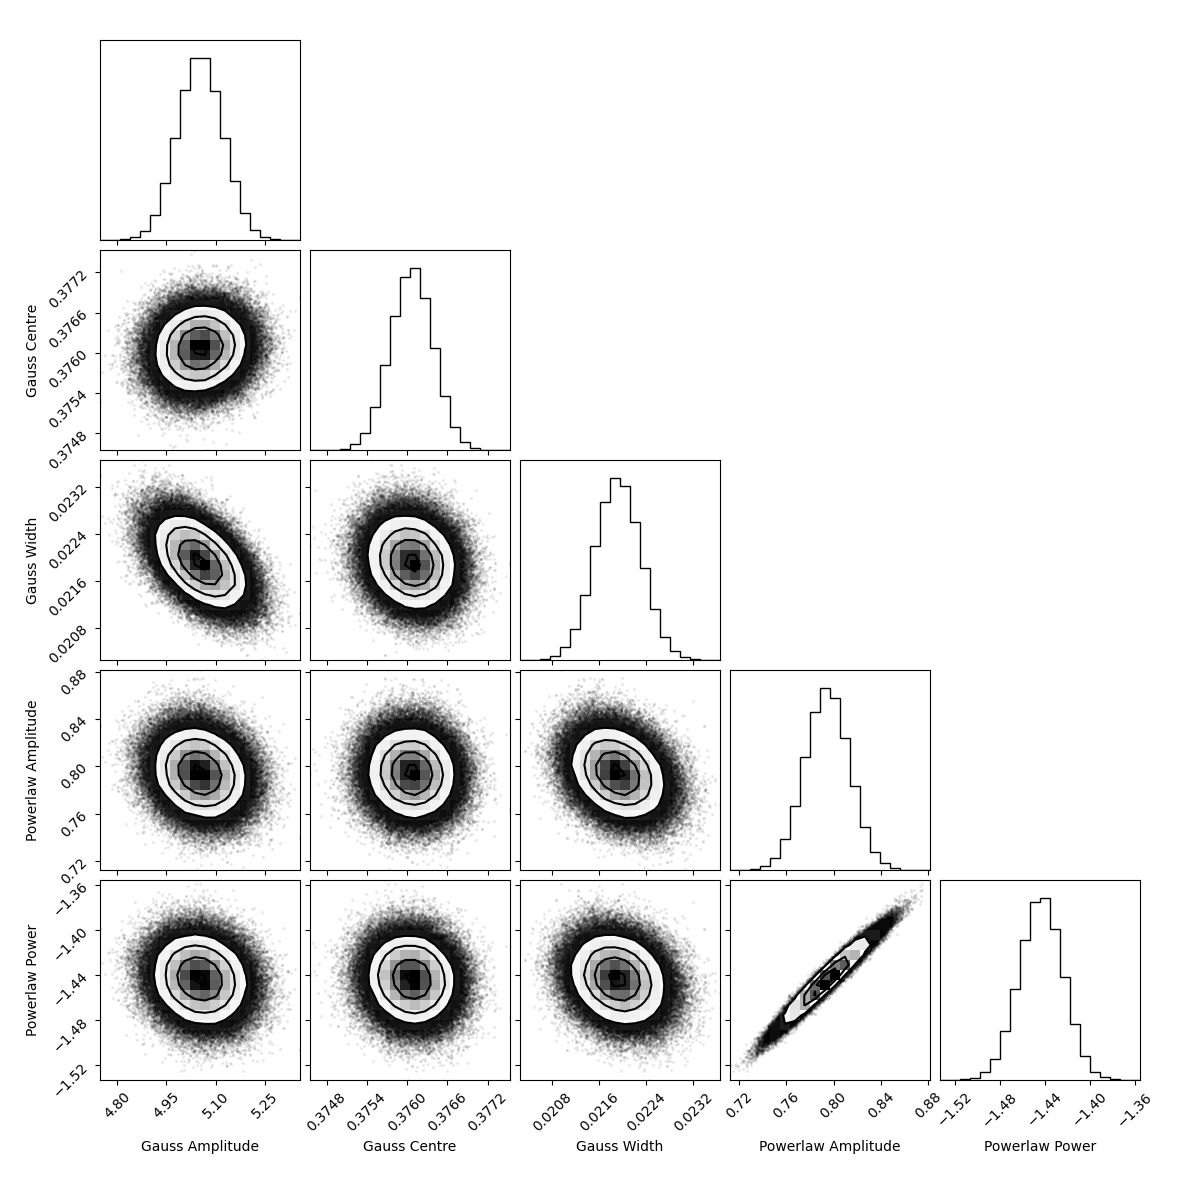

In [253]:
flat_MC_samples = sampler.get_chain(discard=int(tau_max * 3), thin=5, flat=True)
fig = corner.corner(
    flat_MC_samples, labels=gauss_labels, truths=popt
)

Gauss Amplitude  Gauss Centre  Gauss Width  Powerlaw Amplitude  Powerlaw Power
Peak #4 Fit           4.388066      0.378968     0.027643            1.112611       -1.350097
Peak #4 Error         0.011706      0.000077     0.000104            0.008363        0.005636
MCMC Fit              4.389509      0.378527     0.027804            1.091343       -1.364454
MCMC LB Error        -0.059006     -0.000416    -0.000475           -0.020971       -0.015831
MCMC UB Error         0.059275      0.000413     0.000480            0.021194        0.015660

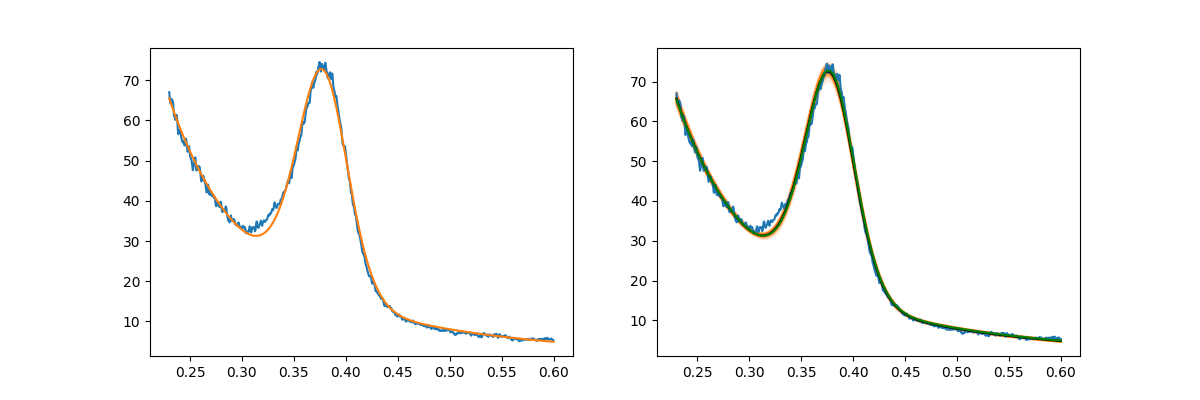

In [220]:
# Plot the result of the Least Squares fit and the MCMC fit
fig, ax = plt.subplots(1, 2, figsize=(12, 4))


ax[0].plot(q0_OOP_TR[idxs], I0_OOP_TR[idxs], label="Data")
ax[0].plot(q, fit_fn_gau(q, *popt), label="Least Squares Fit")
ax[0].fill_between(q, fit_fn_gau(q, *popt - np.sqrt(np.diag(pcov))), fit_fn_gau(q, *popt + np.sqrt(np.diag(pcov))), alpha=0.1)
                   
# Plot the MCMC fit
MC_samples = sampler.get_chain(discard=200, thin=5, flat=True)
percentiles = [np.percentile(MC_samples[:, i], [16, 50, 84]) for i in range(MC_samples.shape[1])] #Sampling at 1 sigma percentiles
values = [p[1] for p in percentiles]
error_bounds = np.array([[p[0] - p[1], p[2] - p[1]] for p in percentiles])


inds = np.random.randint(len(MC_samples), size=100)
for ind in inds:
    sample = MC_samples[ind]
    ax[1].plot(q, fit_fn_gau(q, *sample), "C1", alpha=0.1, label="MCMC Fit" if ind == inds[0] else None)
ax[1].plot(q0_OOP_TR[idxs], I0_OOP_TR[idxs], label="Data")
ax[1].plot(q, fit_fn_gau(q, *values), 'black', label="MCMC Fit")
ax[1].plot(q, fit_fn_gau(q, *popt), label="Least Squares Fit", c='green')


display(pd.DataFrame(
    [popt, np.sqrt(np.diag(pcov)), values, error_bounds[:,0], error_bounds[:,1]],
    columns=gauss_labels,
    index=[f"Peak #{i} Fit", f"Peak #{i} Error", "MCMC Fit", "MCMC LB Error", "MCMC UB Error"]
))

### Perform analysis across all samples

In [29]:
MCMC_SAMPLING : bool = False
"""Whether to use MCMC sampling to fit the data or not"""
N: int = 200
"""The number of walkers to use in the MCMC sampling"""
M = 1000
"""The default number of steps to use in the MCMC sampling"""

dataset_fits: list[list[list[np.ndarray]]] = []
"""For each sample, for each file, for each peak, a set of the fit results, containing the popt and error bounds"""
dataset_MC_fits: list[list[list[np.ndarray]]] = []
"""For each sample, for each file, for each peak, a set of the MCMC opt values, and lb/ub"""

for i, sample in enumerate(samples):
    # Setup sample dependent variables
    sample_fits = []
    sample_MC_fits = []
    dataset_fits.append(sample_fits)
    dataset_MC_fits.append(sample_MC_fits)
    
    # Create the results directory for the sample
    sample_dir = os.path.join(RESULT_DIR, sample)
    if not os.path.isdir(sample_dir):
        os.mkdir(sample_dir)
    giwaxs_img_dir = os.path.join(sample_dir, "giwaxs_flatfielded_images")
    if not os.path.isdir(giwaxs_img_dir):
        os.mkdir(giwaxs_img_dir)
    mcmc_img_dir = os.path.join(sample_dir, "mcmc_fit_images")
    if not os.path.isdir(mcmc_img_dir):
        os.mkdir(mcmc_img_dir)
    fits_img_dir = os.path.join(sample_dir, "ls_fit_images")
    if not os.path.isdir(fits_img_dir):
        os.mkdir(fits_img_dir)
    line_profiles_dir = os.path.join(sample_dir, "line_profiles")
    if not os.path.isdir(line_profiles_dir):
        os.mkdir(line_profiles_dir)
        
    # Loop over all files in the sample dataset
    for j, fname in enumerate(datasets[i]):
        file_fits = []
        file_MC_fits = []
        sample_fits.append(file_fits)
        sample_MC_fits.append(file_MC_fits)
        
        # Setup a figure and open the file
        fig,ax = plt.subplots(1,1, figsize=(7, 10), dpi=300)
        # Collect the metadata
        en_idx = fname.find('eV_')
        en = float(fname[en_idx-7:en_idx])
        ai_idx = fname.find("_ai")
        ai = float(fname[ai_idx+3:ai_idx+8])
        # Update the geometry
        SMI_waxs.alphai = np.deg2rad(ai)
        SMI_waxs.wav = en2wav(en)
        
        # Plot the flatfield / masked normalized data
        SMI_waxs.open_data(RAW_DIR, [fname])
        apply_detector_mask(SMI_waxs)
        apply_flatfield(SMI_waxs, flatfield)
        SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)
        mp = ax.imshow(SMI_waxs.img_st,
                extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
        # mp = ax.imshow(np.rot90(SMI_waxs.img_st.T,2),
                # extent=[SMI_waxs.qz[0], SMI_waxs.qz[-1], SMI_waxs.qp[0], SMI_waxs.qp[-1]], 
                vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                vmax=np.percentile(SMI_waxs.img_st, 99.0) # Avoid extremities
        )
        plt.colorbar(mp)
        ax.set_title(f"{sample}\n{en} eV - {ai} deg")
        fig.savefig(os.path.join(giwaxs_img_dir, f"{sample}_giwaxs_{en}eV_{ai}deg.png"))
        
        if j==0:
            # Plot the azimuthal and radial angles
            colors = ['r', 'orange', 'white'][::-1]
            for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
                # Generate a set of x points to plot lines of.
                q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
                # Calculate the x and y gradients for the lines
                m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
                m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
                # Calculate the x & y values for the lines
                q_x1 = q_x if m1 != np.inf else np.zeros(100)
                q_x2 = q_x if m2 != np.inf else np.zeros(100)
                y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                # Plot the lines
                color = colors.pop()
                ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
                ax.plot(q_x2, y2, color=color, linestyle='-')
                # If gradient is inf, calculate an alternative fill between
                if m2 == np.inf:
                        ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
                else:
                        ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
            ax.set_xlim(*SMI_waxs.qp)
            ax.set_ylim(*SMI_waxs.qz)
            ax.legend()
            fig.savefig(os.path.join(sample_dir, f"{sample}_line_profile_angles.png"), dpi=300)
        plt.close() # Save memory
        
        # Perform the radial/azimuthal averaging
        # In plane and out of plane
        SMI_waxs.radial_averaging(radial_range = [0, 8], 
            azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
            npt = NPOINTS_RADIAL_AVE)
        q0_IP, I0_IP = SMI_waxs.q_rad, SMI_waxs.I_rad
        SMI_waxs.radial_averaging(radial_range = [0, 8], 
            azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
            npt = NPOINTS_RADIAL_AVE)
        q0_OOP, I0_OOP = SMI_waxs.q_rad, SMI_waxs.I_rad
        # Repeat IP and OOP for the consistency checking
        SMI_waxs.radial_averaging(radial_range = [0, 8], 
            azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
            npt = NPOINTS_RADIAL_AVE)
        q0_IP2, I0_IP2 = SMI_waxs.q_rad, SMI_waxs.I_rad
        SMI_waxs.radial_averaging(radial_range = [0, 8], 
            azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
            npt = NPOINTS_RADIAL_AVE)
        q0_OOP2, I0_OOP2 = SMI_waxs.q_rad, SMI_waxs.I_rad
        # Radial averaging
        SMI_waxs.radial_averaging(radial_range = [0, 8], 
            azimuth_range=[AZIMUTHAL_RADIAL - RADIAL_WIDTH , AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
            npt = NPOINTS_RADIAL_AVE)
        q0_R, I0_R = SMI_waxs.q_rad, SMI_waxs.I_rad
        # Repeat radial averaging for consistency checking
        SMI_waxs.radial_averaging(radial_range = [0, 8], 
            azimuth_range=[180-AZIMUTHAL_RADIAL - RADIAL_WIDTH , 180-AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
            npt = NPOINTS_RADIAL_AVE)
        q0_R2, I0_R2 = SMI_waxs.q_rad, SMI_waxs.I_rad
        
        # Save the line profiles 
        header = "Main Data\t\tMirror-Y axis Data\t\n" + "q (Å^-1)\tI (a.u.)\tq (Å^-1)\tI (a.u.)"
        delim = "\t"
        kwargs = {"header": header, "delimiter": delim}
        np.savetxt(os.path.join(line_profiles_dir, f"{sample}_line_profile_{en}eV_{ai}deg_IP.txt"), np.array([q0_IP, I0_IP, q0_IP2, I0_IP2]).T, **kwargs)
        np.savetxt(os.path.join(line_profiles_dir, f"{sample}_line_profile_{en}eV_{ai}deg_OOP.txt"), np.array([q0_OOP, I0_OOP, q0_OOP2, I0_OOP2]).T, **kwargs)
        np.savetxt(os.path.join(line_profiles_dir, f"{sample}_line_profile_{en}eV_{ai}deg_R.txt"), np.array([q0_R, I0_R, q0_R2, I0_R2]).T, **kwargs)
        
        # Perform a fit to the data for each listed peak.
        for peak in VERT_PEAKS:
            idx = np.where((q0_OOP > peak[0]) & (q0_OOP < peak[1]))
            q, I = q0_OOP[idx], I0_OOP[idx]
            popt, pcov = curve_fit(fit_fn_gau, q, I, p0=VERT_GUESSES[0], maxfev=10000, bounds=bounds)
            sample_fits.append((popt, np.sqrt(np.diag(pcov))))
            fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
            ax.plot(q, I, label="Data")
            ax.plot(q, fit_fn_gau(q, *popt), label="Least Squares Fit")
            ax.fill_between(q, fit_fn_gau(q, *popt - np.sqrt(np.diag(pcov))), fit_fn_gau(q, *popt + np.sqrt(np.diag(pcov))), alpha=0.1)
            ax.set_title(f"{sample} - {en} eV - {ai} deg - Peak {peak[0]}-{peak[1]}")
            fig.savefig(os.path.join(fits_img_dir, f"{sample}_fit_{en}eV_{ai}deg_peak_{peak[0]}-{peak[1]}.png"))
            plt.close() # Save memory
            
            # Save the peak least squares fit results
            file_fits.append(np.c_[popt, np.sqrt(np.diag(pcov))]) # save fit for each peak.
            
            # Perform the MCMC fit
            pos = popt * np.ones((N, len(popt))) * (1 + (1.0e-2 * np.random.randn(N, len(popt)) - 5.0e-3))
            nwalkers, ndim = pos.shape
            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(x, y, yerr)
            )
            sampler.run_mcmc(pos, M, progress=True)
            # After running for M steps, check the autocorrelation time, and run for more steps if necessary.
            max_tau = None
            while max_tau is None:
                try:
                    tau = sampler.get_autocorr_time()
                    max_tau = np.max(tau)
                except emcee.autocorr.AutocorrError as e:
                    tau_estimate = int(np.max(e.tau))
                    print(f"Estimated max tau: {tau_estimate}, running for {50*tau_estimate} more steps.")
                    sampler.run_mcmc(None, tau_estimate * 50, progress=True)
            
            # Plot the chain output
            fig, axes = plt.subplots(len(gauss_labels), figsize=(10, 2*len(gauss_labels)), sharex=True)
            MC_samples = sampler.get_chain()
            for i in range(ndim):
                ax = axes[i]
                ax.plot(MC_samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(MC_samples))
                ax.set_ylabel(gauss_labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)
            axes[-1].set_xlabel("step number")
            tau_max = np.max(tau)
            fig.suptitle(f"Chain Output - Corr time = {tau_max:0.2f} steps")
            fig.savefig(os.path.join(mcmc_img_dir, f"mcmc_chain_{sample}_{en}eV_{ai}deg_peak_{peak[0]}-{peak[1]}.png"))
            plt.close()
            
            # Create a corner plot        
            flat_MC_samples = sampler.get_chain(discard=int(tau_max * 3), thin=5, flat=True)
            fig = corner.corner(
                flat_MC_samples, labels=gauss_labels, truths=popt
            )
            fig.savefig(os.path.join(mcmc_img_dir, f"corner_plot_{sample}_{en}eV_{ai}deg_peak_{peak[0]}-{peak[1]}.png"))
            plt.close()
            
            # Save the MCMC fit results
            percentiles = [np.percentile(MC_samples[:, i], [16, 50, 84]) for i in range(MC_samples.shape[1])] #Sampling at 1 sigma percentiles
            values = [p[1] for p in percentiles]
            gauss_error = np.array([[p[0] - p[1], p[2] - p[1]] for p in percentiles])
            file_MC_fits.append(np.c_[np.array(values), gauss_error[:,0], gauss_error[:,1]])
        
    
    # Save the fits from each sample to text file
    file_fits = np.array(file_fits) # (Files, Peaks, (Parameters, Errors))
    header = "\t".join(["Fit Params"] + ["" for _ in range(len(gauss_labels)-1)] + ["Fit Errors"] + ["" for _ in range(len(gauss_labels)-1)] + ["Data Properties"])
    header = header + "\n" + "\t".join(gauss_labels + [label + "_unc" for label in gauss_labels] + ["Integrated Area from q=0.13 to 0.15 (A.U)"])
    delim = "\t"
    kwargs = {"header": header, "delimiter": delim}
    np.savetxt(os.path.join(sample_dir, f"{sample}_fits.txt"), 
               np.reshape(file_fits, (file_fits.shape[0], np.prod(file_fits.shape[1:]))),  #make the array 2D
               **kwargs)
    
    # Save the MCMC fits from each sample to text file
    file_MC_fits = np.array(file_MC_fits) # (Files, Peaks, (Parameters, ErrorLB, ErrorUB))
    header = "\t".join(["MC Fit Params"] + ["" for _ in range(len(gauss_labels)-1)] + ["MC LB Errors"] + ["" for _ in range(len(gauss_labels)-1)] + ["MC UB Errors"] + ["" for _ in range(len(gauss_labels)-1)])
    header = header + "\n" + "\t".join(gauss_labels + [label + "_unc_lb" for label in gauss_labels] + [label + "_unc_ub" for label in gauss_labels])
    delim = "\t"
    kwargs = {"header": header, "delimiter": delim}
    np.savetxt(os.path.join(sample_dir, f"{sample}_mcmc_fits.txt"), 
               np.reshape(file_MC_fits, (file_MC_fits.shape[0], np.prod(file_MC_fits.shape[1:]))),  #make the array 2D
               **kwargs)
    

C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.35it/s]


Estimated max tau: 82, running for 4100 more steps.


100%|██████████| 4100/4100 [00:54<00:00, 75.86it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.43it/s]


Estimated max tau: 74, running for 3700 more steps.


100%|██████████| 3700/3700 [00:50<00:00, 73.25it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.30it/s]


Estimated max tau: 82, running for 4100 more steps.


100%|██████████| 4100/4100 [00:53<00:00, 76.63it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.18it/s]


Estimated max tau: 78, running for 3900 more steps.


100%|██████████| 3900/3900 [00:50<00:00, 76.92it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 74.69it/s]


Estimated max tau: 81, running for 4050 more steps.


100%|██████████| 4050/4050 [00:53<00:00, 75.58it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:14<00:00, 70.85it/s]


Estimated max tau: 82, running for 4100 more steps.


100%|██████████| 4100/4100 [00:55<00:00, 73.28it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.62it/s]


Estimated max tau: 80, running for 4000 more steps.


100%|██████████| 4000/4000 [00:52<00:00, 76.75it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 74.06it/s]


Estimated max tau: 73, running for 3650 more steps.


100%|██████████| 3650/3650 [00:49<00:00, 73.26it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.32it/s]


Estimated max tau: 76, running for 3800 more steps.


100%|██████████| 3800/3800 [00:50<00:00, 75.26it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.13it/s]


Estimated max tau: 84, running for 4200 more steps.


100%|██████████| 4200/4200 [00:55<00:00, 75.70it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.46it/s]


Estimated max tau: 67, running for 3350 more steps.


100%|██████████| 3350/3350 [00:45<00:00, 73.38it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.21it/s]


Estimated max tau: 69, running for 3450 more steps.


100%|██████████| 3450/3450 [00:45<00:00, 76.39it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 74.36it/s]


Estimated max tau: 63, running for 3150 more steps.


100%|██████████| 3150/3150 [00:41<00:00, 75.48it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.35it/s]


Estimated max tau: 72, running for 3600 more steps.


100%|██████████| 3600/3600 [00:49<00:00, 72.90it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 74.43it/s]


Estimated max tau: 67, running for 3350 more steps.


100%|██████████| 3350/3350 [00:43<00:00, 76.61it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 71.96it/s]


Estimated max tau: 64, running for 3200 more steps.


100%|██████████| 3200/3200 [00:43<00:00, 73.01it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.73it/s]


Estimated max tau: 60, running for 3000 more steps.


100%|██████████| 3000/3000 [00:40<00:00, 73.23it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.65it/s]


Estimated max tau: 69, running for 3450 more steps.


100%|██████████| 3450/3450 [00:47<00:00, 72.19it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:14<00:00, 70.19it/s]


Estimated max tau: 74, running for 3700 more steps.


100%|██████████| 3700/3700 [00:52<00:00, 70.76it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:14<00:00, 71.37it/s]


Estimated max tau: 70, running for 3500 more steps.


100%|██████████| 3500/3500 [00:48<00:00, 71.63it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.68it/s]


Estimated max tau: 61, running for 3050 more steps.


100%|██████████| 3050/3050 [00:41<00:00, 72.81it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:14<00:00, 70.68it/s]


Estimated max tau: 64, running for 3200 more steps.


100%|██████████| 3200/3200 [00:46<00:00, 69.56it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.88it/s]


Estimated max tau: 66, running for 3300 more steps.


100%|██████████| 3300/3300 [00:45<00:00, 73.23it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.89it/s]


Estimated max tau: 68, running for 3400 more steps.


100%|██████████| 3400/3400 [00:46<00:00, 73.77it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.89it/s]


Estimated max tau: 60, running for 3000 more steps.


100%|██████████| 3000/3000 [00:38<00:00, 77.69it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.41it/s]


Estimated max tau: 63, running for 3150 more steps.


100%|██████████| 3150/3150 [00:41<00:00, 75.89it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.21it/s]


Estimated max tau: 76, running for 3800 more steps.


100%|██████████| 3800/3800 [00:51<00:00, 73.17it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.48it/s]


Estimated max tau: 69, running for 3450 more steps.


100%|██████████| 3450/3450 [00:44<00:00, 77.29it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.06it/s]


Estimated max tau: 67, running for 3350 more steps.


100%|██████████| 3350/3350 [00:43<00:00, 76.21it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.95it/s]


Estimated max tau: 65, running for 3250 more steps.


100%|██████████| 3250/3250 [00:44<00:00, 73.57it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.12it/s]


Estimated max tau: 68, running for 3400 more steps.


100%|██████████| 3400/3400 [00:44<00:00, 76.73it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.01it/s]


Estimated max tau: 65, running for 3250 more steps.


100%|██████████| 3250/3250 [00:42<00:00, 75.98it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.28it/s]


Estimated max tau: 67, running for 3350 more steps.


100%|██████████| 3350/3350 [00:43<00:00, 76.98it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.72it/s]


Estimated max tau: 75, running for 3750 more steps.


100%|██████████| 3750/3750 [00:48<00:00, 77.12it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.69it/s]


Estimated max tau: 68, running for 3400 more steps.


100%|██████████| 3400/3400 [00:44<00:00, 76.49it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.17it/s]


Estimated max tau: 68, running for 3400 more steps.


100%|██████████| 3400/3400 [00:44<00:00, 75.97it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.76it/s]


Estimated max tau: 67, running for 3350 more steps.


100%|██████████| 3350/3350 [00:43<00:00, 76.82it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.65it/s]


Estimated max tau: 61, running for 3050 more steps.


100%|██████████| 3050/3050 [00:41<00:00, 73.94it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.93it/s]


Estimated max tau: 68, running for 3400 more steps.


100%|██████████| 3400/3400 [00:44<00:00, 76.54it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.16it/s]


Estimated max tau: 62, running for 3100 more steps.


100%|██████████| 3100/3100 [00:40<00:00, 77.23it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 71.85it/s]


Estimated max tau: 67, running for 3350 more steps.


100%|██████████| 3350/3350 [00:46<00:00, 71.91it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.33it/s]


Estimated max tau: 72, running for 3600 more steps.


100%|██████████| 3600/3600 [00:46<00:00, 76.75it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.29it/s]


Estimated max tau: 65, running for 3250 more steps.


100%|██████████| 3250/3250 [00:42<00:00, 76.14it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.74it/s]


Estimated max tau: 68, running for 3400 more steps.


100%|██████████| 3400/3400 [00:44<00:00, 76.51it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.57it/s]


Estimated max tau: 69, running for 3450 more steps.


100%|██████████| 3450/3450 [00:45<00:00, 75.56it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.05it/s]


Estimated max tau: 63, running for 3150 more steps.


100%|██████████| 3150/3150 [00:41<00:00, 76.75it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.78it/s]


Estimated max tau: 80, running for 4000 more steps.


100%|██████████| 4000/4000 [00:51<00:00, 76.97it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.81it/s]


Estimated max tau: 81, running for 4050 more steps.


100%|██████████| 4050/4050 [00:52<00:00, 76.91it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.40it/s]


Estimated max tau: 80, running for 4000 more steps.


100%|██████████| 4000/4000 [00:53<00:00, 74.56it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.51it/s]


Estimated max tau: 82, running for 4100 more steps.


100%|██████████| 4100/4100 [00:53<00:00, 76.77it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.27it/s]


Estimated max tau: 75, running for 3750 more steps.


100%|██████████| 3750/3750 [00:48<00:00, 77.28it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.26it/s]


Estimated max tau: 67, running for 3350 more steps.


100%|██████████| 3350/3350 [00:44<00:00, 76.13it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.60it/s]


Estimated max tau: 63, running for 3150 more steps.


100%|██████████| 3150/3150 [00:43<00:00, 73.12it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.19it/s]


Estimated max tau: 66, running for 3300 more steps.


100%|██████████| 3300/3300 [00:43<00:00, 76.16it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.56it/s]


Estimated max tau: 73, running for 3650 more steps.


100%|██████████| 3650/3650 [00:47<00:00, 76.86it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 74.28it/s]


Estimated max tau: 72, running for 3600 more steps.


100%|██████████| 3600/3600 [00:48<00:00, 74.31it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.14it/s]


Estimated max tau: 76, running for 3800 more steps.


100%|██████████| 3800/3800 [00:49<00:00, 77.18it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.65it/s]


Estimated max tau: 65, running for 3250 more steps.


100%|██████████| 3250/3250 [00:43<00:00, 75.29it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.69it/s]


Estimated max tau: 83, running for 4150 more steps.


100%|██████████| 4150/4150 [00:53<00:00, 77.20it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.07it/s]


Estimated max tau: 77, running for 3850 more steps.


100%|██████████| 3850/3850 [00:50<00:00, 76.74it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.09it/s]


Estimated max tau: 82, running for 4100 more steps.


100%|██████████| 4100/4100 [00:53<00:00, 76.31it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.09it/s]


Estimated max tau: 73, running for 3650 more steps.


100%|██████████| 3650/3650 [00:47<00:00, 76.50it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.47it/s]


Estimated max tau: 86, running for 4300 more steps.


100%|██████████| 4300/4300 [00:57<00:00, 74.59it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:15<00:00, 66.08it/s]


Estimated max tau: 72, running for 3600 more steps.


100%|██████████| 3600/3600 [00:48<00:00, 74.30it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.31it/s]


Estimated max tau: 81, running for 4050 more steps.


100%|██████████| 4050/4050 [00:55<00:00, 73.15it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.51it/s]


Estimated max tau: 81, running for 4050 more steps.


100%|██████████| 4050/4050 [00:52<00:00, 76.47it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.83it/s]


Estimated max tau: 72, running for 3600 more steps.


100%|██████████| 3600/3600 [00:47<00:00, 76.56it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.25it/s]


Estimated max tau: 79, running for 3950 more steps.


100%|██████████| 3950/3950 [00:51<00:00, 77.03it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 72.04it/s]


Estimated max tau: 76, running for 3800 more steps.


100%|██████████| 3800/3800 [00:49<00:00, 76.65it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.30it/s]


Estimated max tau: 87, running for 4350 more steps.


100%|██████████| 4350/4350 [00:56<00:00, 76.33it/s]


Estimated max tau: 117, running for 5850 more steps.


100%|██████████| 5850/5850 [01:15<00:00, 77.97it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.60it/s]


Estimated max tau: 87, running for 4350 more steps.


100%|██████████| 4350/4350 [00:56<00:00, 77.58it/s]


Estimated max tau: 121, running for 6050 more steps.


100%|██████████| 6050/6050 [01:19<00:00, 76.53it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.02it/s]


Estimated max tau: 91, running for 4550 more steps.


100%|██████████| 4550/4550 [00:59<00:00, 76.72it/s]


Estimated max tau: 121, running for 6050 more steps.


100%|██████████| 6050/6050 [01:18<00:00, 76.98it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 78.97it/s]


Estimated max tau: 94, running for 4700 more steps.


100%|██████████| 4700/4700 [00:59<00:00, 78.86it/s]


Estimated max tau: 149, running for 7450 more steps.


100%|██████████| 7450/7450 [01:36<00:00, 77.39it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 73.40it/s]


Estimated max tau: 93, running for 4650 more steps.


100%|██████████| 4650/4650 [01:02<00:00, 74.57it/s]


Estimated max tau: 145, running for 7250 more steps.


100%|██████████| 7250/7250 [01:36<00:00, 75.06it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.80it/s]


Estimated max tau: 86, running for 4300 more steps.


100%|██████████| 4300/4300 [00:55<00:00, 77.28it/s]


Estimated max tau: 111, running for 5550 more steps.


100%|██████████| 5550/5550 [01:13<00:00, 75.20it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 74.42it/s]


Estimated max tau: 93, running for 4650 more steps.


100%|██████████| 4650/4650 [01:02<00:00, 74.25it/s]


Estimated max tau: 151, running for 7550 more steps.


100%|██████████| 7550/7550 [01:42<00:00, 73.42it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:14<00:00, 69.91it/s]


Estimated max tau: 97, running for 4850 more steps.


100%|██████████| 4850/4850 [00:56<00:00, 85.47it/s]


Estimated max tau: 260, running for 13000 more steps.


100%|██████████| 13000/13000 [02:42<00:00, 79.82it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.71it/s]


Estimated max tau: 91, running for 4550 more steps.


100%|██████████| 4550/4550 [00:58<00:00, 78.11it/s]


Estimated max tau: 130, running for 6500 more steps.


100%|██████████| 6500/6500 [01:23<00:00, 77.45it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 75.39it/s]


Estimated max tau: 103, running for 5150 more steps.


100%|██████████| 5150/5150 [01:02<00:00, 82.18it/s]


Estimated max tau: 181, running for 9050 more steps.


100%|██████████| 9050/9050 [01:46<00:00, 84.63it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 74.38it/s]


Estimated max tau: 94, running for 4700 more steps.


100%|██████████| 4700/4700 [01:03<00:00, 74.26it/s]


Estimated max tau: 146, running for 7300 more steps.


100%|██████████| 7300/7300 [01:35<00:00, 76.61it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.93it/s]


Estimated max tau: 90, running for 4500 more steps.


100%|██████████| 4500/4500 [00:57<00:00, 77.80it/s]


Estimated max tau: 127, running for 6350 more steps.


100%|██████████| 6350/6350 [01:23<00:00, 76.31it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.66it/s]


Estimated max tau: 91, running for 4550 more steps.


100%|██████████| 4550/4550 [00:58<00:00, 77.25it/s]


Estimated max tau: 126, running for 6300 more steps.


100%|██████████| 6300/6300 [01:20<00:00, 78.04it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 78.86it/s]


Estimated max tau: 88, running for 4400 more steps.


100%|██████████| 4400/4400 [00:56<00:00, 78.06it/s]


Estimated max tau: 140, running for 7000 more steps.


100%|██████████| 7000/7000 [01:29<00:00, 78.30it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 79.70it/s]


Estimated max tau: 96, running for 4800 more steps.


100%|██████████| 4800/4800 [00:59<00:00, 80.32it/s]


Estimated max tau: 140, running for 7000 more steps.


100%|██████████| 7000/7000 [01:24<00:00, 82.40it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:13<00:00, 76.20it/s]


Estimated max tau: 95, running for 4750 more steps.


100%|██████████| 4750/4750 [01:03<00:00, 75.34it/s]


Estimated max tau: 132, running for 6600 more steps.


100%|██████████| 6600/6600 [01:26<00:00, 76.35it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 83.05it/s]


Estimated max tau: 114, running for 5700 more steps.


100%|██████████| 5700/5700 [01:11<00:00, 79.58it/s]


Estimated max tau: 278, running for 13900 more steps.


100%|██████████| 13900/13900 [02:55<00:00, 79.21it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 77.52it/s]


Estimated max tau: 107, running for 5350 more steps.


100%|██████████| 5350/5350 [01:09<00:00, 76.49it/s]


Estimated max tau: 178, running for 8900 more steps.


100%|██████████| 8900/8900 [01:56<00:00, 76.41it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
  0%|          | 0/1000 [00:00<?, ?it/s]d:\Github\smi-analysis\venv\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:12<00:00, 78.10it/s]


Estimated max tau: 116, running for 5800 more steps.


100%|██████████| 5800/5800 [01:13<00:00, 79.19it/s]


Estimated max tau: 268, running for 13400 more steps.


100%|██████████| 13400/13400 [02:42<00:00, 82.32it/s]


Estimated max tau: 440, running for 22000 more steps.


100%|██████████| 22000/22000 [04:28<00:00, 81.84it/s]
C:\Users\mgebert\AppData\Local\Temp\ipykernel_18256\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
  0%|          | 0/1000 [00:00<?, ?it/s]d:\Github\smi-analysis\venv\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:10<00:00, 96.30it/s]


Estimated max tau: 109, running for 5450 more steps.


100%|██████████| 5450/5450 [00:54<00:00, 100.44it/s]


Estimated max tau: 444, running for 22200 more steps.


100%|██████████| 22200/22200 [03:39<00:00, 101.14it/s]


<IPython.core.display.Javascript object>


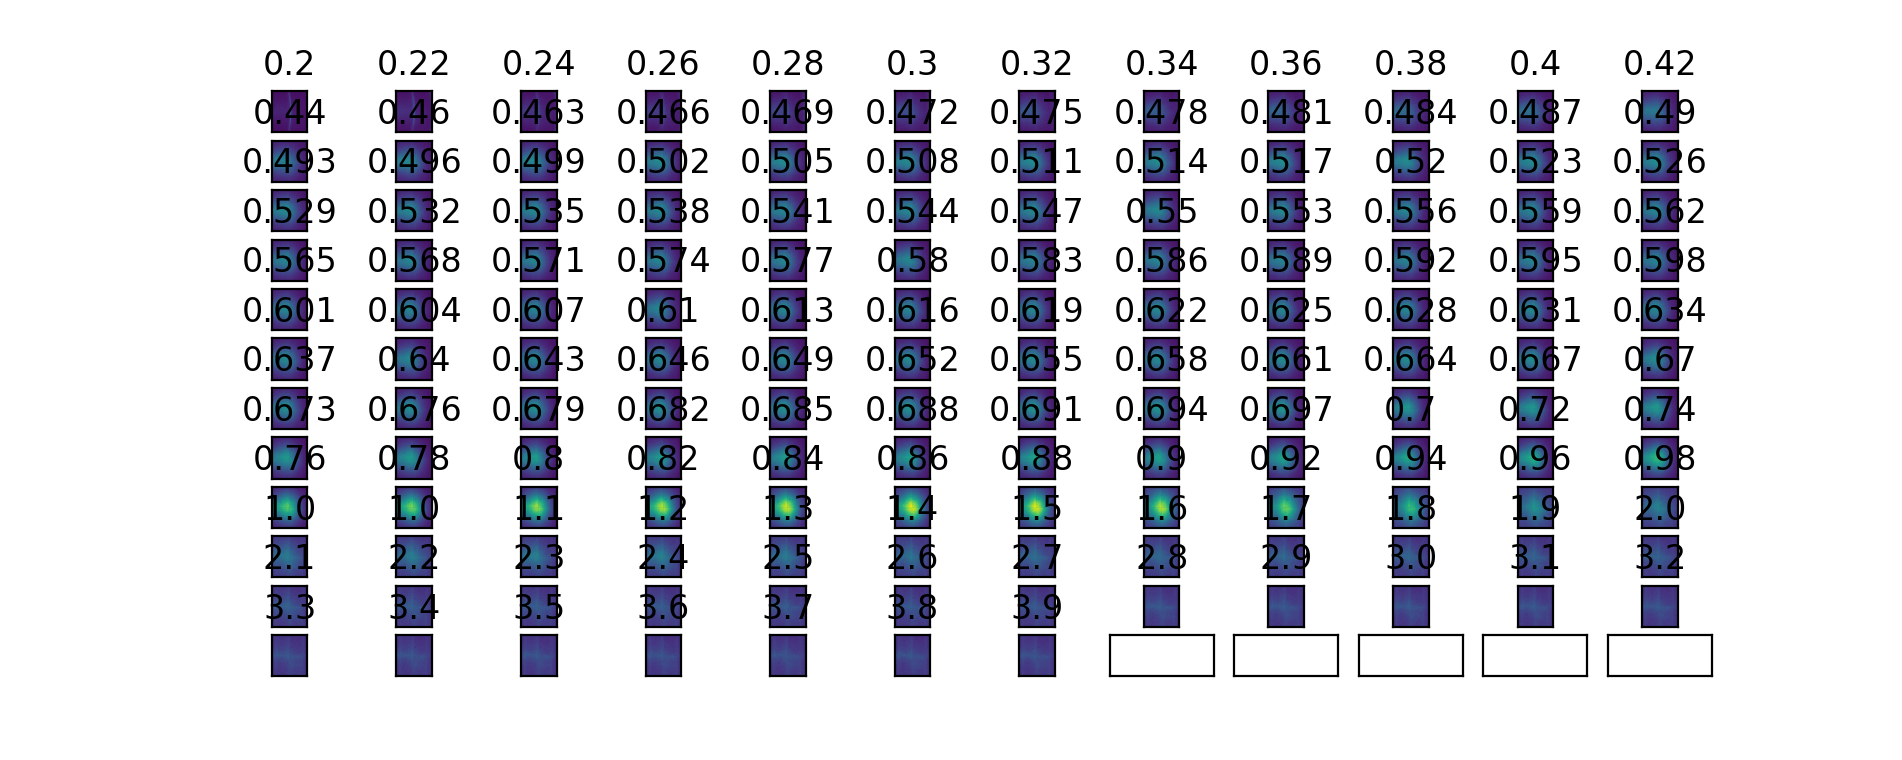

In [96]:
N = len(all_dat[0])
r, c = int(np.floor(np.sqrt(N)+1)), int(np.floor(np.sqrt(N)+1))
fig, ax = plt.subplots(r,c, figsize = (3,3))

for j, dat in enumerate([all_dat[0]]):
    for j, da in enumerate(dat):
        idx = da.find('_ai')
        ai = float(da[idx+3:idx+8])
        img=fabio.open(os.path.join(RAW_DIR, da)).data
        ax[int(np.floor(j/r)),int(j%r)].imshow(img[partial_peak], vmin=0, vmax=200)
        ax[int(np.floor(j/r)),int(j%r)].set_title(f"{ai}")
        
for ax_row in ax:
    for axis in ax_row:
        axis.set_xticks([])
        axis.set_yticks([])
        

In [97]:
print(all_dat[0])

['CM_wideincidentanglescan_A5_02_2450.00eV_ai0.200_wa0_bpm122.535_id797158_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.220_wa0_bpm122.552_id797159_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.240_wa0_bpm122.517_id797160_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.260_wa0_bpm122.587_id797161_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.280_wa0_bpm122.644_id797162_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.300_wa0_bpm122.556_id797163_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.320_wa0_bpm122.489_id797164_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.340_wa0_bpm122.513_id797165_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.360_wa0_bpm122.579_id797166_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.380_wa0_bpm122.620_id797167_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.400_wa0_bpm122.501_id797168_00000

# Load the flatfielding data

In [ ]:
# Past beamline data for flat fielding (normalizing default pixel intensities)
# Note this is done at 2478eV
CYCLE_FLAT = '2024_3'
PROPOSAL_FLAT= '314483-Freychet-Flatfielding'
FLAT_PATH = '/nsls2/data/smi/legacy/results/data/%s/%s/900KW/'%(CYCLE_FLAT, PROPOSAL_FLAT)
flatfield = fabio.open(os.path.join(FLAT_PATH, 'GF_flatfield_Sedge_2450uhighg1600_WZY11_wa30deg_2478eV_20s_id701601_000000_WAXS.tif')).data

fig,ax = plt.subplots(1,1)
ax.imshow(flatfield, vmin=0, vmax=100)
flatfield = flatfield.T
ax.set_title("Flatfielding Data")

## Data stitching and reduction (all this part is done using SMI_beamline package)

<IPython.core.display.Javascript object>


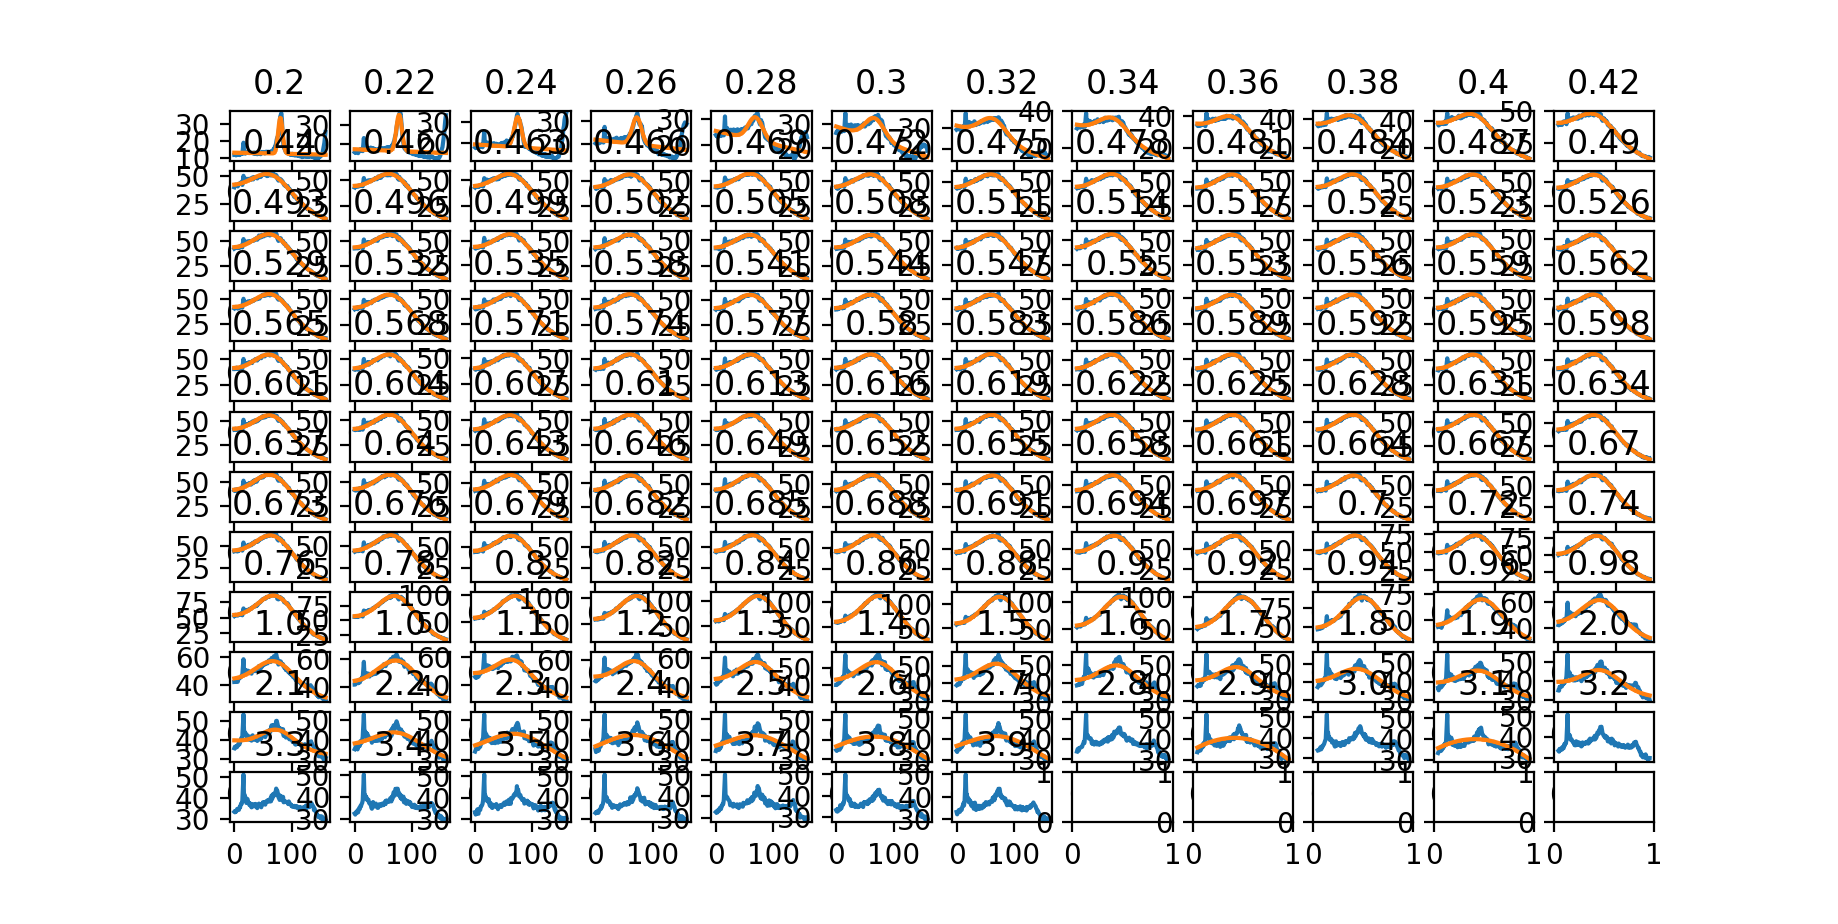

No convergence for 2.8
No convergence for 3.0
No convergence for 3.2
No convergence for 3.3
No convergence for 3.4
No convergence for 3.5
No convergence for 3.6
No convergence for 3.7
No convergence for 3.8
No convergence for 3.9
Done


array([  21.16,   19.54,   14.3 ,   11.51,    8.95,    8.7 ,    9.97,
         11.23,   13.62,   15.78,   17.77,   20.15,   23.45,   26.72,
         27.02,   28.02,   27.72,   27.47,   28.29,   28.03,   28.59,
         28.14,   28.13,   28.32,   28.08,   27.8 ,   27.66,   27.92,
         27.22,   27.54,   28.36,   27.59,   28.52,   28.08,   27.47,
         27.3 ,   26.93,   26.98,   27.09,   27.33,   27.62,   27.45,
         27.55,   27.17,   26.99,   26.61,   26.95,   26.93,   27.33,
         27.47,   27.22,   27.68,   27.72,   27.05,   28.08,   28.32,
         27.85,   28.29,   28.48,   28.42,   27.97,   28.28,   28.42,
         28.35,   28.4 ,   28.74,   28.82,   28.5 ,   29.45,   30.26,
         29.75,   30.31,   30.92,   30.28,   30.66,   30.93,   31.09,
         31.41,   31.57,   32.06,   32.28,   32.83,   33.51,   33.66,
         33.55,   34.17,   34.55,   34.36,   34.29,   36.  ,   36.91,
         36.89,   37.4 ,   38.57,   41.94,   46.46,   51.7 ,   56.82,
         61.83,   66

In [98]:
#waxs
flag_save = True
RAW_DIR = '/nsls2/data/smi/legacy/results/data/%s/%s/900KW/'%(CYCLE, PROPOSAL_ID)
ResDir = '/nsls2/data/smi/legacy/results/analysis/%s/%s/reduced_waxs/'%(CYCLE, PROPOSAL_ID)

sumall = []
sumall1 = []
sumall2 = []
enall=[]
aiall=[]
ampall=[]
errall=[]
ampall2=[]
errall2=[]

# id0 = 774550
# ia_list = np.r_[np.arange(0.2,0.46,0.02), np.arange(0.46, 0.7, 0.003), np.arange(0.7,0.9,0.002)]

N = len(all_dat[0])
r, c = int(np.floor(np.sqrt(N)+1)), int(np.floor(np.sqrt(N)+1))
fig, ax = plt.subplots(r,c, figsize = (3,3))

from scipy.stats import norm
from scipy.optimize import curve_fit

gauss = lambda x, amp, x0,gamma, grad, offset: amp*np.exp(-(x-x0)**2/(2*gamma**2)) + grad*x + offset
guess = [28.41527437, 95.61914598, 33.17924886, -0.16900728, 41.95497869]
lb = [0,        0,        0,  -20, 10]
ub = [np.inf,   np.inf , 50, 20,  70]

for i, dat in enumerate([all_dat[0]]):
    for j, da in enumerate(dat):
#         id_idx = all_dat[0][j].find("_id")
#         print(all_dat[0][j][id_idx+3: id_idx+9])
#         id_num = int(all_dat[0][j][id_idx+3: id_idx+9])
#         ia = ia_list[id_num - id0]
        idx = da.find('_ai')
        ai = float(da[idx+3:idx+8])
    
        img=fabio.open(os.path.join(RAW_DIR, da)).data
        sumall += [np.sum(img[partial_peak])]
        sumall1 += [np.sum(img[partial_beam])]
        
        hor_sum = np.mean(img[partial_peak[0]], axis=0)
        hor_sum_subset = hor_sum[partial_peak[1]]

        pixelNo = np.linspace(0,hor_sum_subset.shape[0]-1,hor_sum_subset.shape[0])
        
        p0 = (guess if popt is None else popt) #use past fit value if not None.
        
        ax[int(np.floor(j/r)),int(j%r)].plot(pixelNo, hor_sum_subset)
        ax[int(np.floor(j/r)),int(j%r)].set_title(f"{ai}")
        try:
            popt, pcov = curve_fit(gauss, pixelNo, hor_sum_subset, p0=p0)
        except RuntimeError:
            print(f"No convergence for {ai}")
            popt, pcov = [np.nan]*5, [[np.nan]*5]*5
            
        ampall += [popt[0]]
        errall += [np.sqrt(np.diag(pcov))[0]]
        
        aiall += [ai]
        
        if np.isnan(popt[0]):
            popt = None
        elif len(popt) == 5:
            ax[int(np.floor(j/r)),int(j%r)].plot(pixelNo, gauss(pixelNo, *popt), marker=".", markersize=0.2)

print('Done')
display(np.around(ampall,2))

<IPython.core.display.Javascript object>


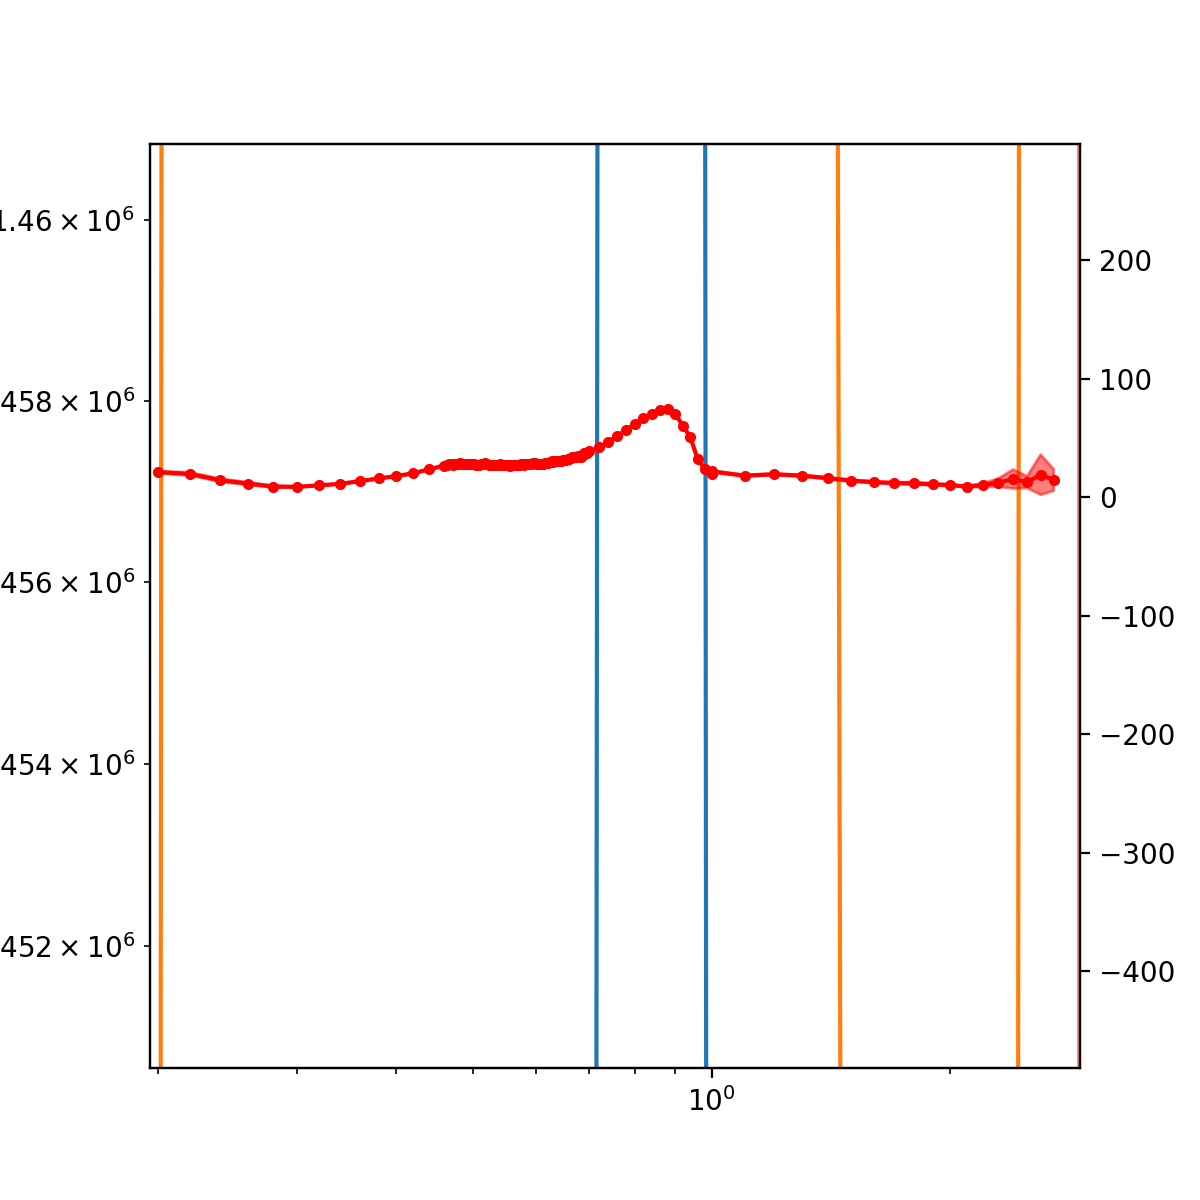

In [99]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.set_yscale("log")
idxs = np.array(aiall).argsort()
sorted_ai = np.array(aiall)[idxs]
sorted_sum = np.array(sumall)[idxs]
sorted_sum1 = np.array(sumall1)[idxs]
sorted_sumamp = np.array(ampall)[idxs]
sorted_err = np.array(errall)[idxs]
plt.plot(sorted_ai, sorted_sum, marker=".")
plt.plot(sorted_ai, sorted_sum1, marker=".")
ax2 = plt.twinx()
ax2.plot(sorted_ai, sorted_sumamp, marker=".", c="red")
ax2.fill_between(sorted_ai, sorted_sumamp - sorted_err, sorted_sumamp + sorted_err, alpha=0.5, color="red")
plt.xscale("log")
plt.show()

In [14]:
ids = [name[-22:-16] for name in  all_dat[0]]
display(min(ids), max(ids))

'784259'

'784397'